In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor, AdaptParams, AdaptiveMixtureSampler

from production.utils import summarize_depths_by_return_period
from production.metrics import metrics
from production.plots import plot_return_period_summary, plot_two_return_period_summaries
from production.plots import plot_adaptive_evolution


In [3]:
watershed_names = ["Trinity","Kanawha","Duwamish","Denton"]

In [4]:
#Load data
watersheds = {}

for wname in watershed_names:
    ws = Preprocessor.load(
        config_path=f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{wname}/config.json"
    )
    watersheds[wname] = ws

In [5]:
#Full Monte Carlo summary
base_dir = "/workspaces/Importance-Sampling-for-SST/data/1_interim"
summary_filename = "fullmonte_summary.pq"

# --- load summaries ---
summaries = {}
for w in watershed_names:
    path = os.path.join(base_dir, w, summary_filename)
    df = pd.read_parquet(path)
    needed = {"RP","median_in","ci95_low_in","ci95_high_in"}
    if not needed <= set(df.columns):
        raise ValueError(f"{w}: summary missing columns {needed - set(df.columns)}")
    summaries[w] = df.sort_values("RP")

In [6]:
watershed = watersheds["Trinity"]

In [ ]:
params = AdaptParams(
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"],
    sd_y_n=watershed.watershed_stats["range_y"],

    mu_x_w=watershed.domain_stats["x"],
    mu_y_w=watershed.domain_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"]/np.sqrt(12),
    sd_y_w=watershed.domain_stats["range_y"]/np.sqrt(12),

    rho_n=0,      # correlation narrow
    rho_w=0,       # correlation wide
    mix=0.8,         # initial mixture weight for narrow
)

sampler = AdaptiveMixtureSampler(
    data=watershed,                   
    params=params,
    precip_cube=watershed.cumulative_precip,
    seed = 42
)

# Adapt does NOT take data or seed
history = sampler.adapt(num_iterations=10, samples_per_iter=1000)

In [21]:
history

,iter,n,updated,mix,mu_x_n,mu_y_n,sd_x_n,sd_y_n,rho_n,beta_hat_reward
0,0,0,0,0.800000,-47423.503597,1.019272e+06,393466.000014,444468.700707,0.000000,NaN
1,1,2000,1,0.820572,-37581.631478,9.997885e+05,355904.378996,395706.875534,0.040073,0.868573
2,2,2000,1,0.839792,-31356.987419,9.887795e+05,323972.759574,354714.482953,0.052872,0.884639
3,3,2000,1,0.856163,-23288.193251,9.750829e+05,299245.393665,320665.519199,0.076392,0.894364
4,4,2000,1,0.870945,-20382.860805,9.694169e+05,278587.413467,292368.246339,0.096126,0.905435
5,5,2000,1,0.880945,-16101.240174,9.642604e+05,262444.762890,269391.242877,0.105325,0.904280
6,6,2000,1,0.892857,-16687.813258,9.603767e+05,247490.779586,250469.720850,0.116369,0.920650
7,7,2000,1,0.900660,-14985.469655,9.562248e+05,235589.571527,235932.628421,0.130227,0.918869
8,8,2000,1,0.906017,-12578.217410,9.538152e+05,226395.032791,223992.152206,0.134360,0.918516
9,9,2000,1,0.910762,-12152.089043,9.515923e+05,218453.525231,213439.054337,0.126107,0.921835


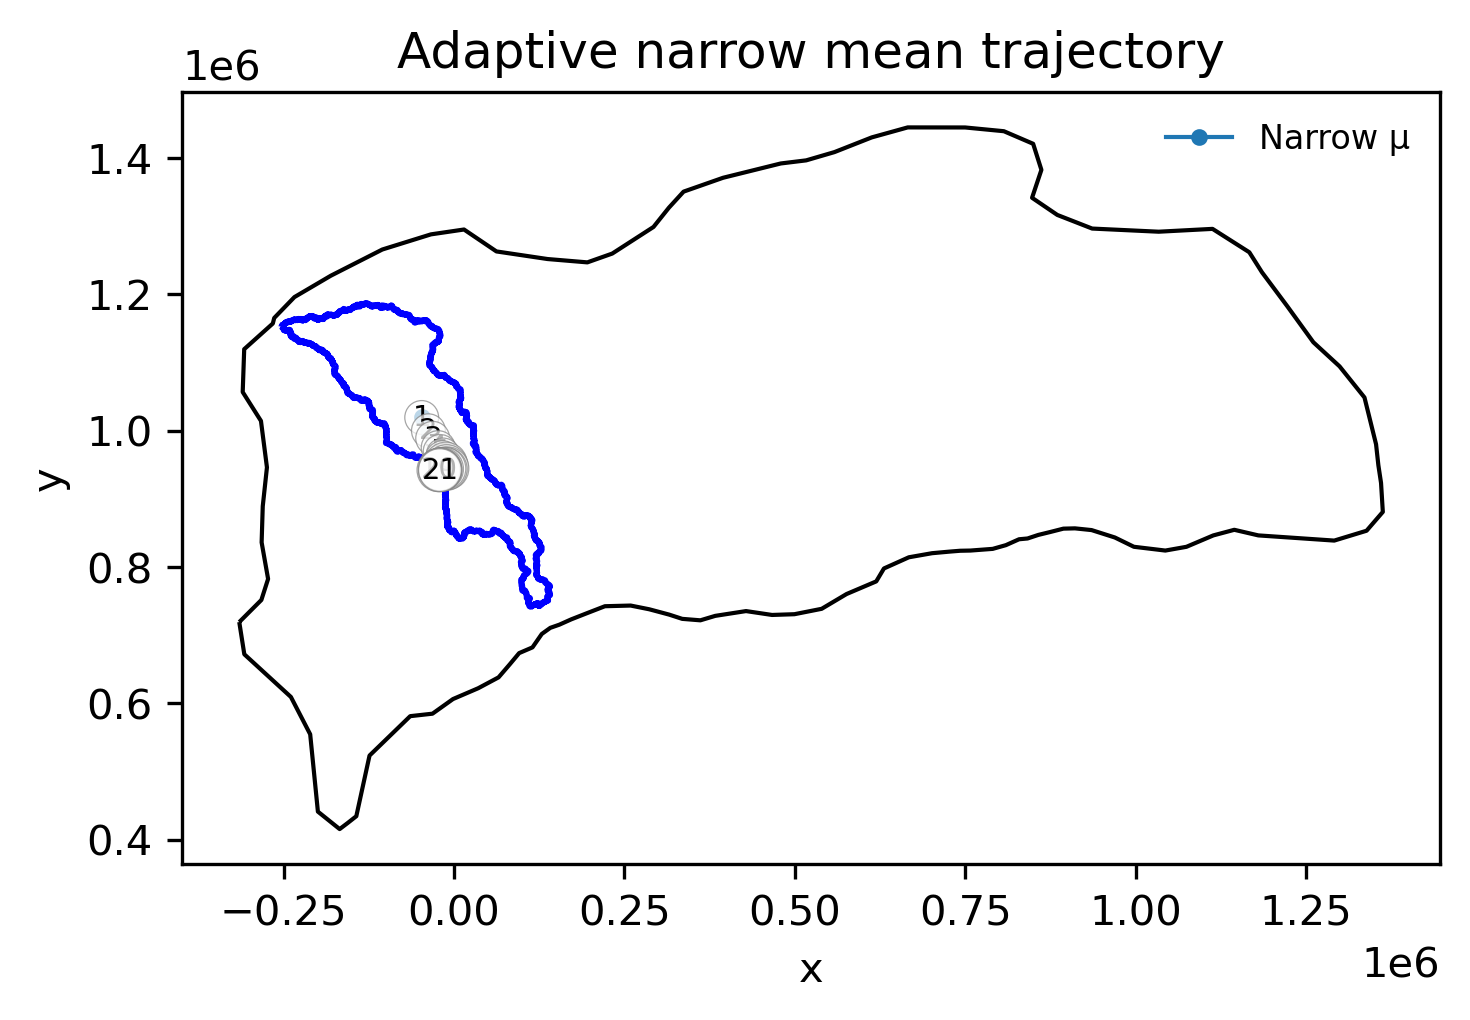

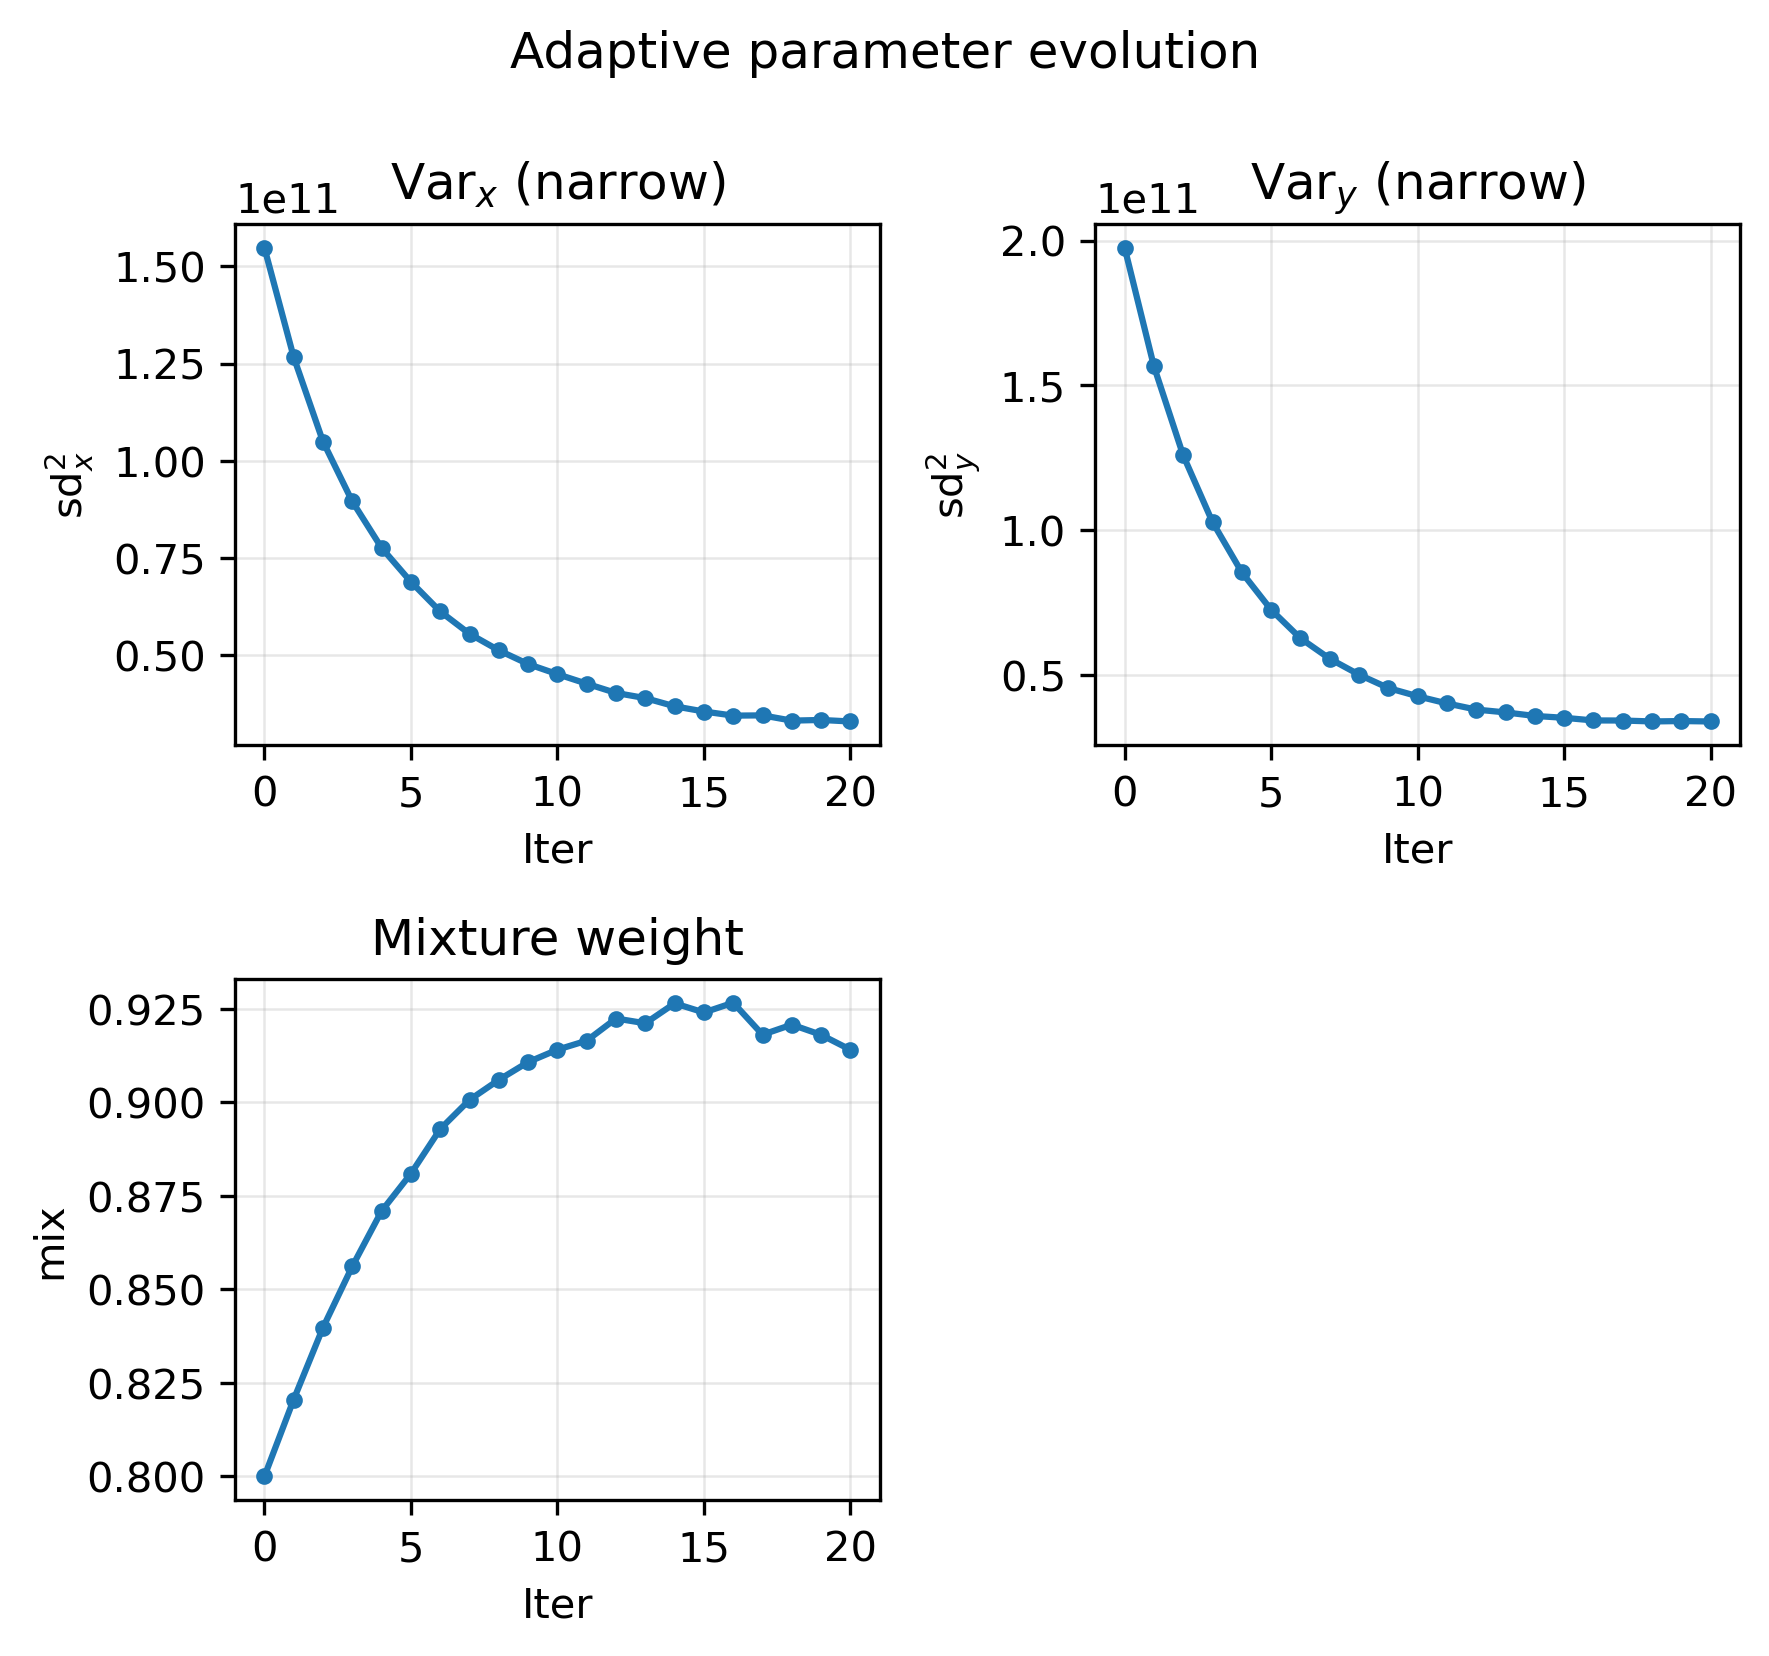

In [22]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="trinity_ais")

In [23]:
final_df = sampler.sample_final(n=12_000, num_realizations=50, with_depths=False)

In [24]:
final_df

,realization,realization_seed,event_id,storm_path,x,y,newx,newy,delx,dely,weight_raw,weight,precip_avg_mm
0,1,1.167567e+19,1,20191029_72hr_st1_r349,722000.0,898000.0,66953.464725,7.935487e+05,-6.550465e+05,-104451.321602,0.464829,0.000039,0.0
1,1,1.167567e+19,2,20061229_72hr_st5_r194,242000.0,946000.0,150953.464725,8.895487e+05,-9.104654e+04,-56451.321602,1.160056,0.000096,0.0
2,1,1.167567e+19,3,20180528_72hr_st5_r148,878000.0,1110000.0,-33046.535275,9.855487e+05,-9.110465e+05,-124451.321602,0.374209,0.000031,0.0
3,1,1.167567e+19,4,20220221_72hr_st1_r368,718000.0,1226000.0,-9046.535275,1.061549e+06,-7.270465e+05,-164451.321602,0.458452,0.000038,0.0
4,1,1.167567e+19,5,19821006_72hr_st1_r147,566000.0,1278000.0,-141046.535275,1.161549e+06,-7.070465e+05,-116451.321602,0.740930,0.000062,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,50,4.153075e+18,11996,19990625_72hr_st3_r233,570000.0,762000.0,202953.464725,7.655487e+05,-3.670465e+05,3548.678398,0.651370,0.000055,0.0
599996,50,4.153075e+18,11997,19791120_72hr_st1_r355,474000.0,1310000.0,-217046.535275,1.181549e+06,-6.910465e+05,-128451.321602,0.966838,0.000081,0.0
599997,50,4.153075e+18,11998,19831121_72hr_st1_r345,450000.0,1094000.0,-93046.535275,1.017549e+06,-5.430465e+05,-76451.321602,0.598398,0.000050,0.0
599998,50,4.153075e+18,11999,19900117_72hr_st1_r044,-58000.0,1034000.0,-17046.535275,1.077549e+06,4.095346e+04,43548.678398,0.829900,0.000069,0.0


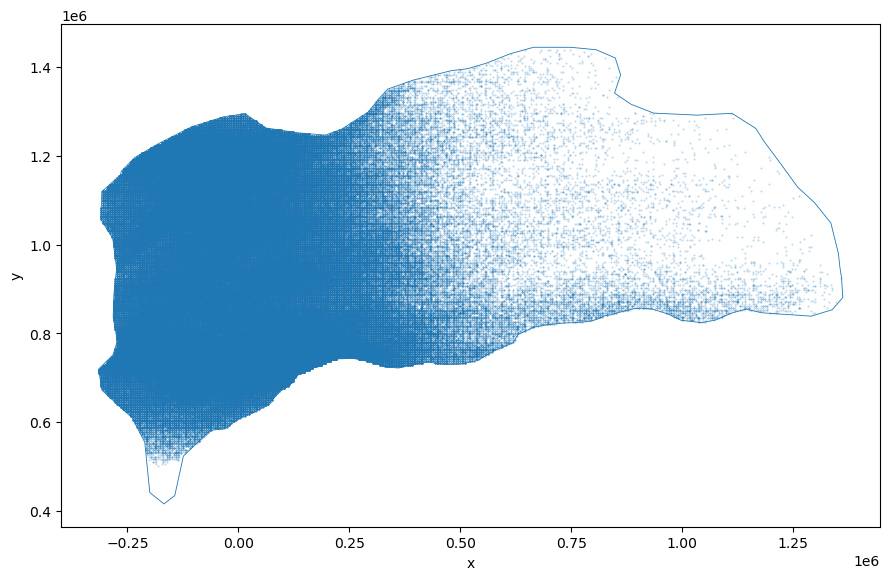

In [16]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(final_df.newx, final_df.newy, s=0.2, alpha=0.3, rasterized=False)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [16]:
adaptive_summary = summarize_depths_by_return_period(
    df=final_df,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
    use_common_min=True
)

In [17]:
m = metrics(summaries["Trinity"],adaptive_summary)
m

,n_points,rp_min_used,rp_max_used,rmse_mean,rmse_median,rmse_ci95_low,rmse_ci95_high,rmse_ci90_low,rmse_ci90_high,me_mean,...,me_ci95_low,me_ci95_high,me_ci90_low,me_ci90_high,diff_at_maxrp_mean,diff_at_maxrp_median,diff_at_maxrp_ci95_low,diff_at_maxrp_ci95_high,diff_at_maxrp_ci90_low,diff_at_maxrp_ci90_high
0,1999,2.0,2000.0,0.031256,0.042353,0.063258,0.032967,0.054114,0.030404,-0.021588,...,-0.030314,-0.016937,-0.027007,-0.019496,-0.039793,-0.050785,-0.061405,-0.019617,-0.024847,-0.024473


In [18]:
adaptive_summary

,RP,mean_in,median_in,ci90_low_in,ci90_high_in,ci95_low_in,ci95_high_in,n_realizations,n_samples_per_realization
0,2,3.845411,3.844428,3.800890,3.888408,3.793582,3.891556,50,12000
1,3,4.346925,4.338137,4.296550,4.406158,4.292717,4.429027,50,12000
2,4,4.621971,4.623089,4.566234,4.687719,4.563009,4.690540,50,12000
3,5,4.808225,4.811523,4.746450,4.878111,4.734979,4.882367,50,12000
4,6,4.938033,4.940356,4.878140,4.995758,4.859133,4.998288,50,12000
...,...,...,...,...,...,...,...,...,...
1994,1996,9.126520,9.144483,8.940509,9.265638,8.892672,9.277211,50,12000
1995,1997,9.126600,9.144508,8.940687,9.265723,8.892709,9.277291,50,12000
1996,1998,9.126681,9.144534,8.940866,9.265807,8.892747,9.277370,50,12000
1997,1999,9.126761,9.144560,8.941044,9.265892,8.892784,9.277450,50,12000


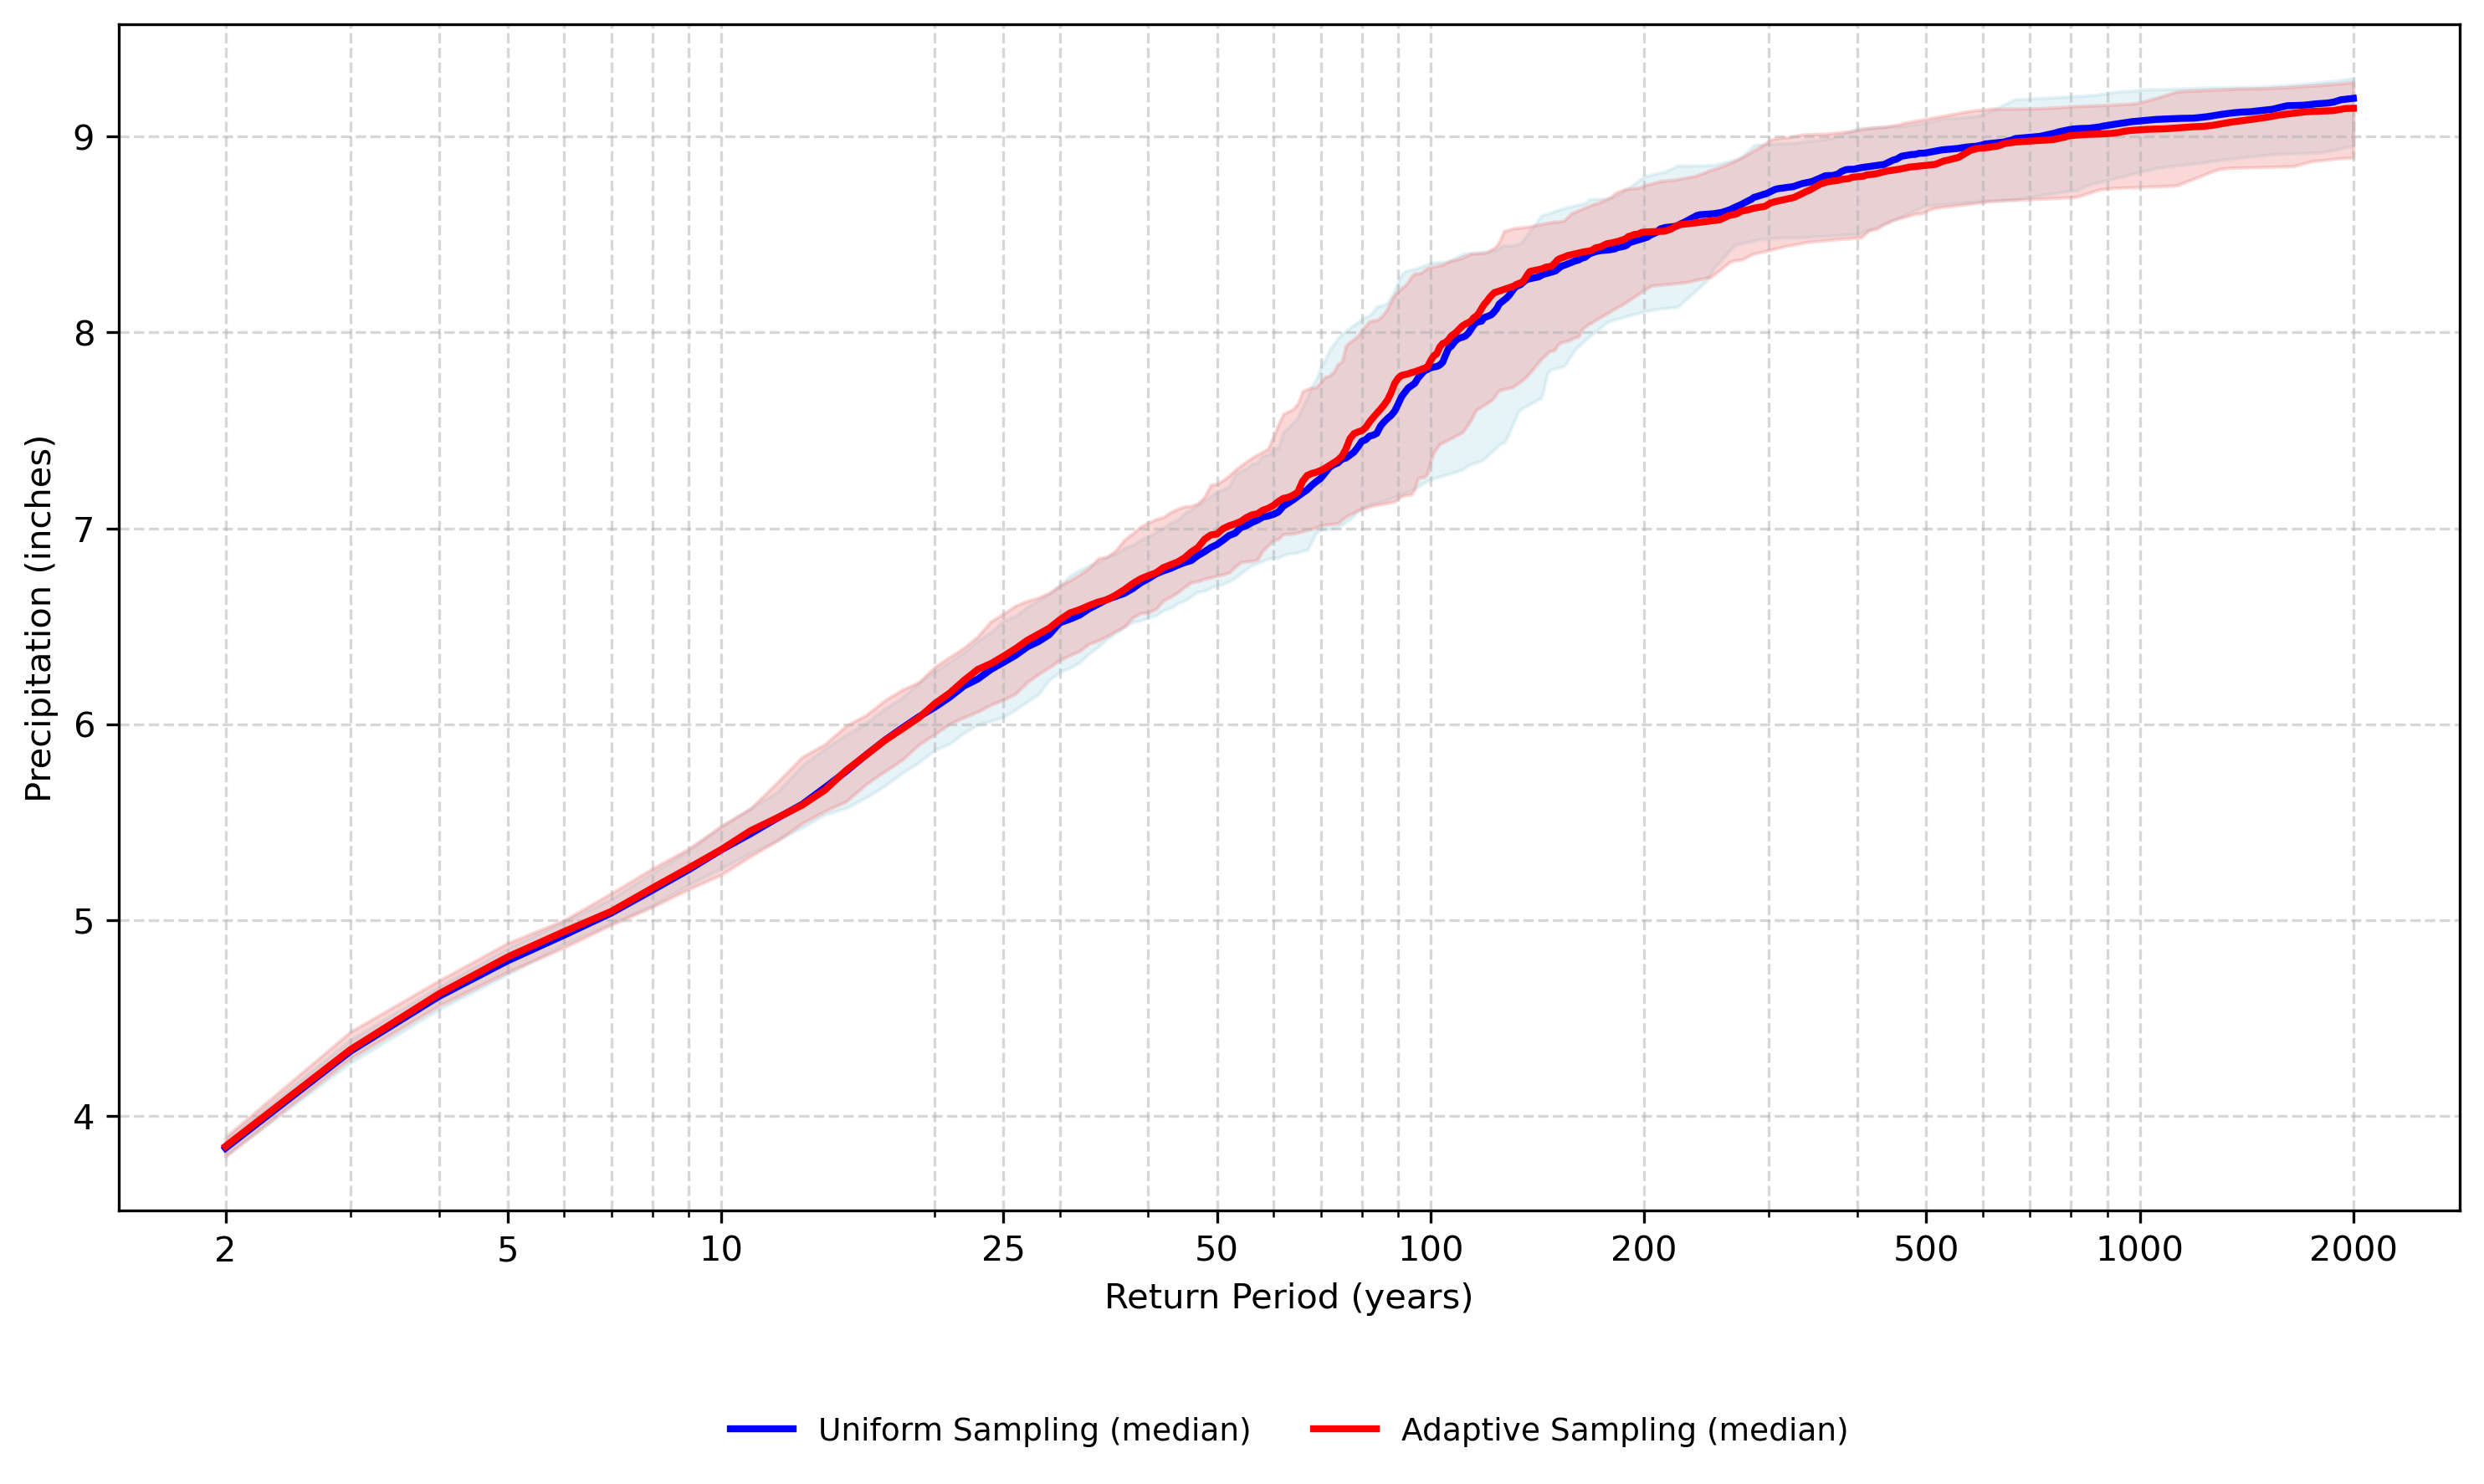

In [19]:
plot_two_return_period_summaries(
    summary1= summaries["Trinity"],          # your first summary DataFrame
    summary2=adaptive_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Adaptive Sampling",
    title=""
)

In [44]:
watershed = watersheds["Kanawha"]

In [45]:
params = AdaptParams(
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"],
    sd_y_n=watershed.watershed_stats["range_y"],

    mu_x_w=watershed.domain_stats["x"],
    mu_y_w=watershed.domain_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"]/np.sqrt(12),
    sd_y_w=watershed.domain_stats["range_y"]/np.sqrt(12),

    rho_n=0,      # correlation narrow
    rho_w=0,       # correlation wide
    mix=0.9,         # initial mixture weight for narrow
)

sampler = AdaptiveMixtureSampler(
    data=watershed,                   
    params=params,
    precip_cube=watershed.cumulative_precip,
    seed=42
)

# Adapt does NOT take data or seed
history = sampler.adapt(num_iterations=10, samples_per_iter=1000, depth_threshold=0)

In [46]:
history

,iter,n,updated,mix,mu_x_n,mu_y_n,sd_x_n,sd_y_n,rho_n,beta_hat_reward
0,0,0,0,0.900000,1.308114e+06,1.738215e+06,218409.555672,316501.199029,0.000000,NaN
1,1,1000,1,0.897468,1.265295e+06,1.651647e+06,173928.992860,220483.332043,0.450095,0.891561
2,2,1000,1,0.904396,1.257804e+06,1.635617e+06,166776.331052,202274.384640,0.583523,0.920562
3,3,1000,1,0.910677,1.249660e+06,1.627619e+06,165696.635448,185756.844143,0.621109,0.925333
4,4,1000,1,0.914582,1.247919e+06,1.619433e+06,158558.921573,180748.205555,0.609027,0.923691
5,5,1000,1,0.918848,1.247978e+06,1.620248e+06,155143.924301,171158.427614,0.589909,0.928805
6,6,1000,1,0.922806,1.244529e+06,1.612830e+06,155632.719036,174197.925838,0.612970,0.932040
7,7,1000,1,0.923929,1.234519e+06,1.607235e+06,155151.406616,175070.688838,0.593962,0.926551
8,8,1000,1,0.929328,1.240266e+06,1.603793e+06,147786.219652,163835.369998,0.576429,0.941926
9,9,1000,1,0.928574,1.237789e+06,1.605911e+06,149814.129769,170281.493590,0.598814,0.926814


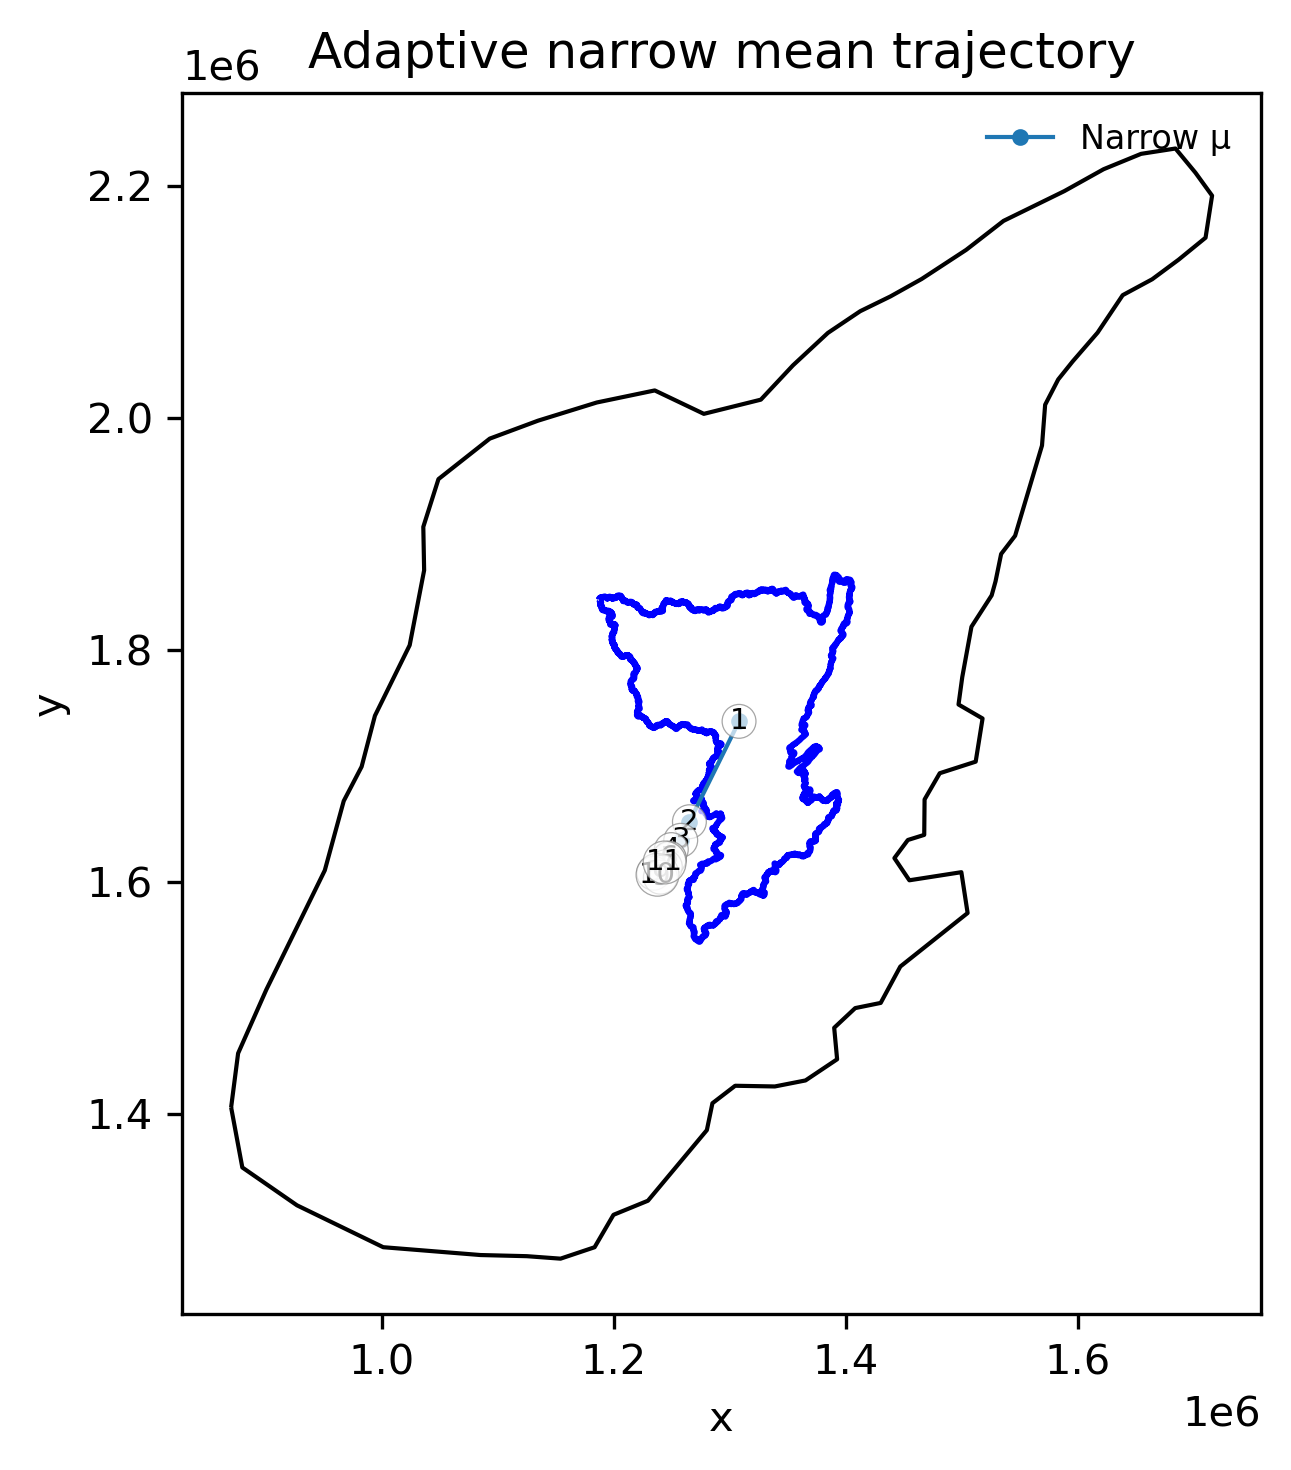

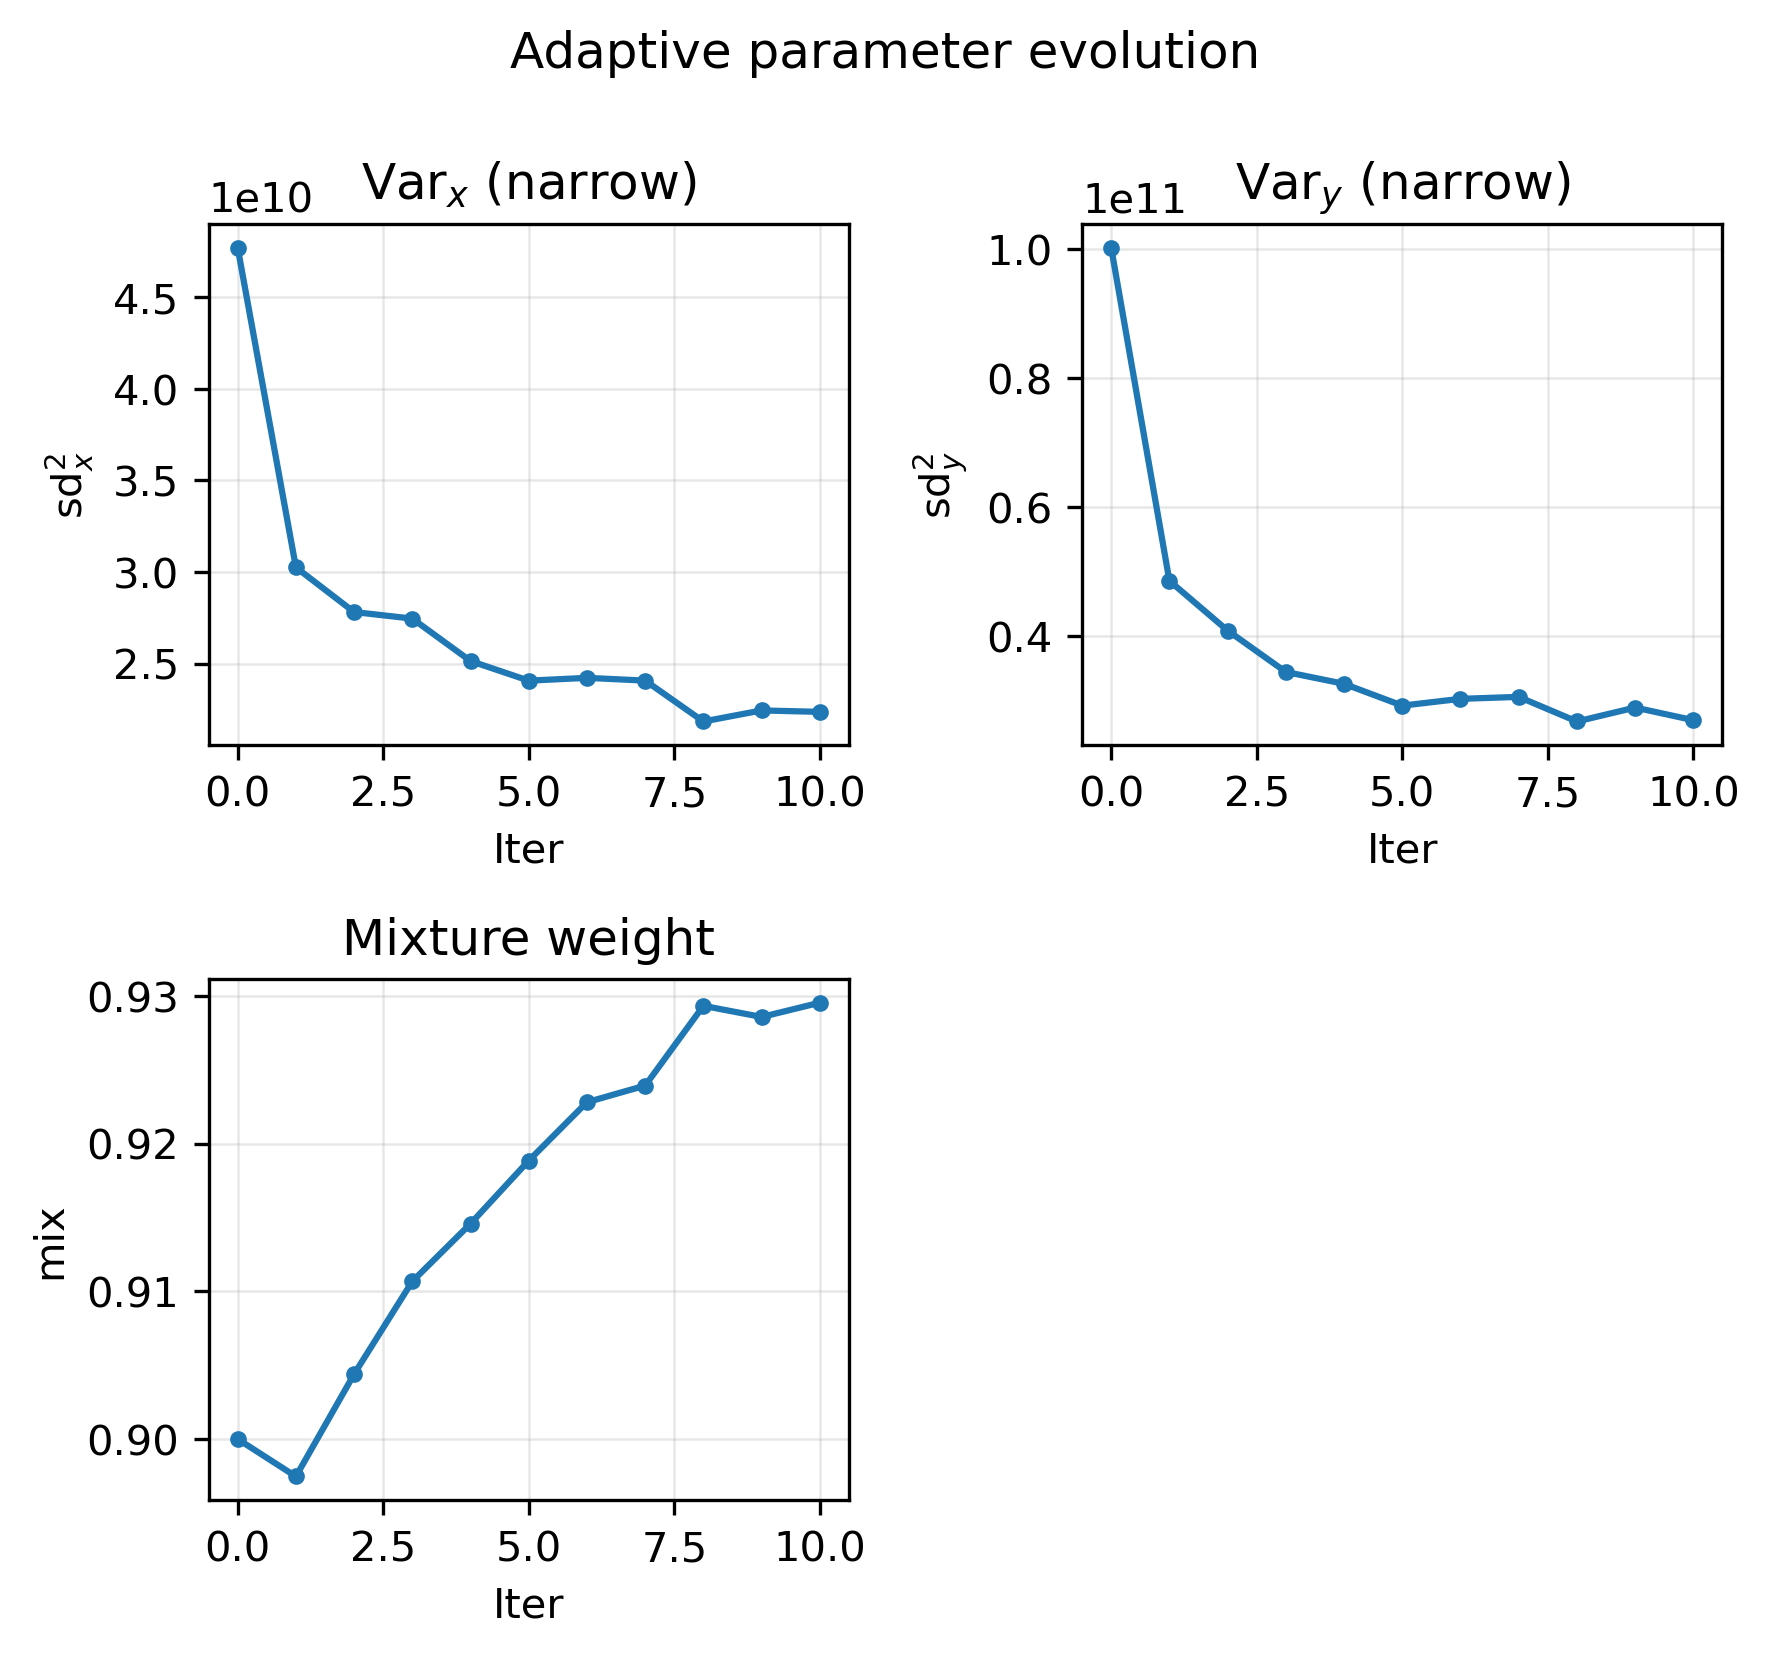

In [47]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="trinity_ais")

In [490]:
final_df = sampler.sample_final(n=10000, num_realizations=50, with_depths=True)

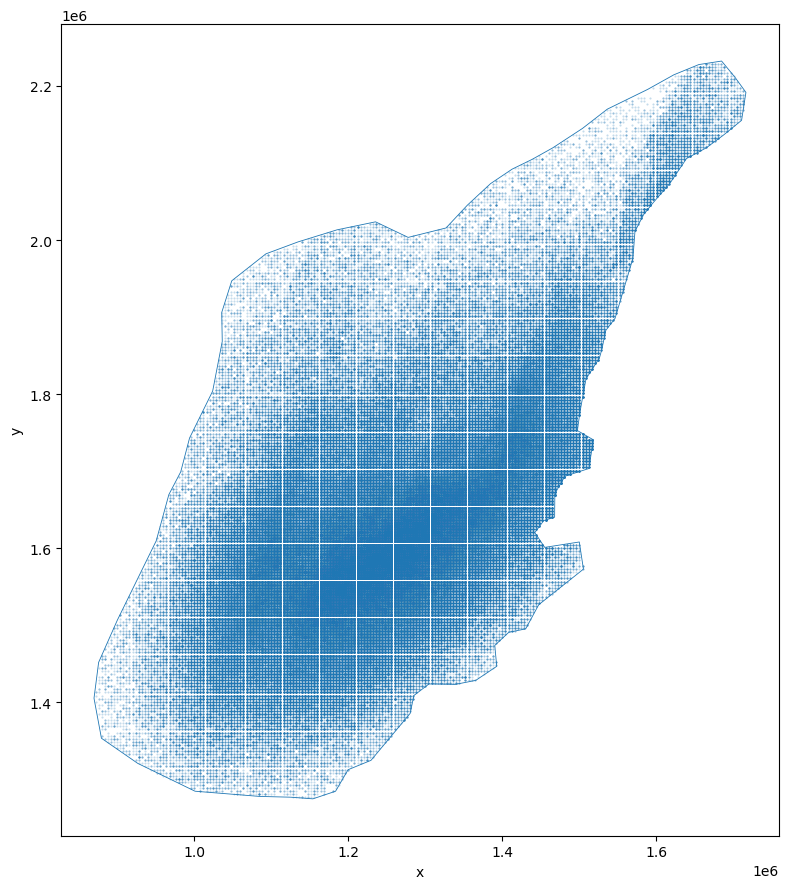

In [491]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(final_df.newx, final_df.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [493]:
adaptive_summary = summarize_depths_by_return_period(
    df=final_df,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
    use_common_min=True
)

In [494]:
m = metrics(summaries["Kanawha"],adaptive_summary)
m

,n_points,rp_min_used,rp_max_used,rmse_mean,rmse_median,rmse_ci95_low,rmse_ci95_high,rmse_ci90_low,rmse_ci90_high,me_mean,...,me_ci95_low,me_ci95_high,me_ci90_low,me_ci90_high,diff_at_maxrp_mean,diff_at_maxrp_median,diff_at_maxrp_ci95_low,diff_at_maxrp_ci95_high,diff_at_maxrp_ci90_low,diff_at_maxrp_ci90_high
0,1999,2.0,2000.0,0.019093,0.019106,0.078605,0.013599,0.037317,0.014649,0.008351,...,0.053264,-0.002133,0.011329,0.005135,0.017071,0.008965,0.063668,-0.020185,0.03707,-0.012633


In [495]:
adaptive_summary

,RP,mean_in,median_in,ci90_low_in,ci90_high_in,ci95_low_in,ci95_high_in,n_realizations,n_samples_per_realization
0,2,2.714751,2.716078,2.678123,2.748607,2.669973,2.752391,50,10000
1,3,3.049845,3.050048,3.003542,3.097031,2.997593,3.102956,50,10000
2,4,3.257130,3.251287,3.197876,3.325924,3.195960,3.347873,50,10000
3,5,3.416727,3.410927,3.360578,3.499775,3.352416,3.503628,50,10000
4,6,3.540978,3.539613,3.480416,3.612729,3.468304,3.614450,50,10000
...,...,...,...,...,...,...,...,...,...
1994,1996,5.659565,5.665851,5.564996,5.725706,5.558096,5.728094,50,10000
1995,1997,5.659605,5.665865,5.565104,5.725731,5.558123,5.728130,50,10000
1996,1998,5.659645,5.665878,5.565212,5.725756,5.558150,5.728167,50,10000
1997,1999,5.659686,5.665892,5.565320,5.725782,5.558177,5.728204,50,10000


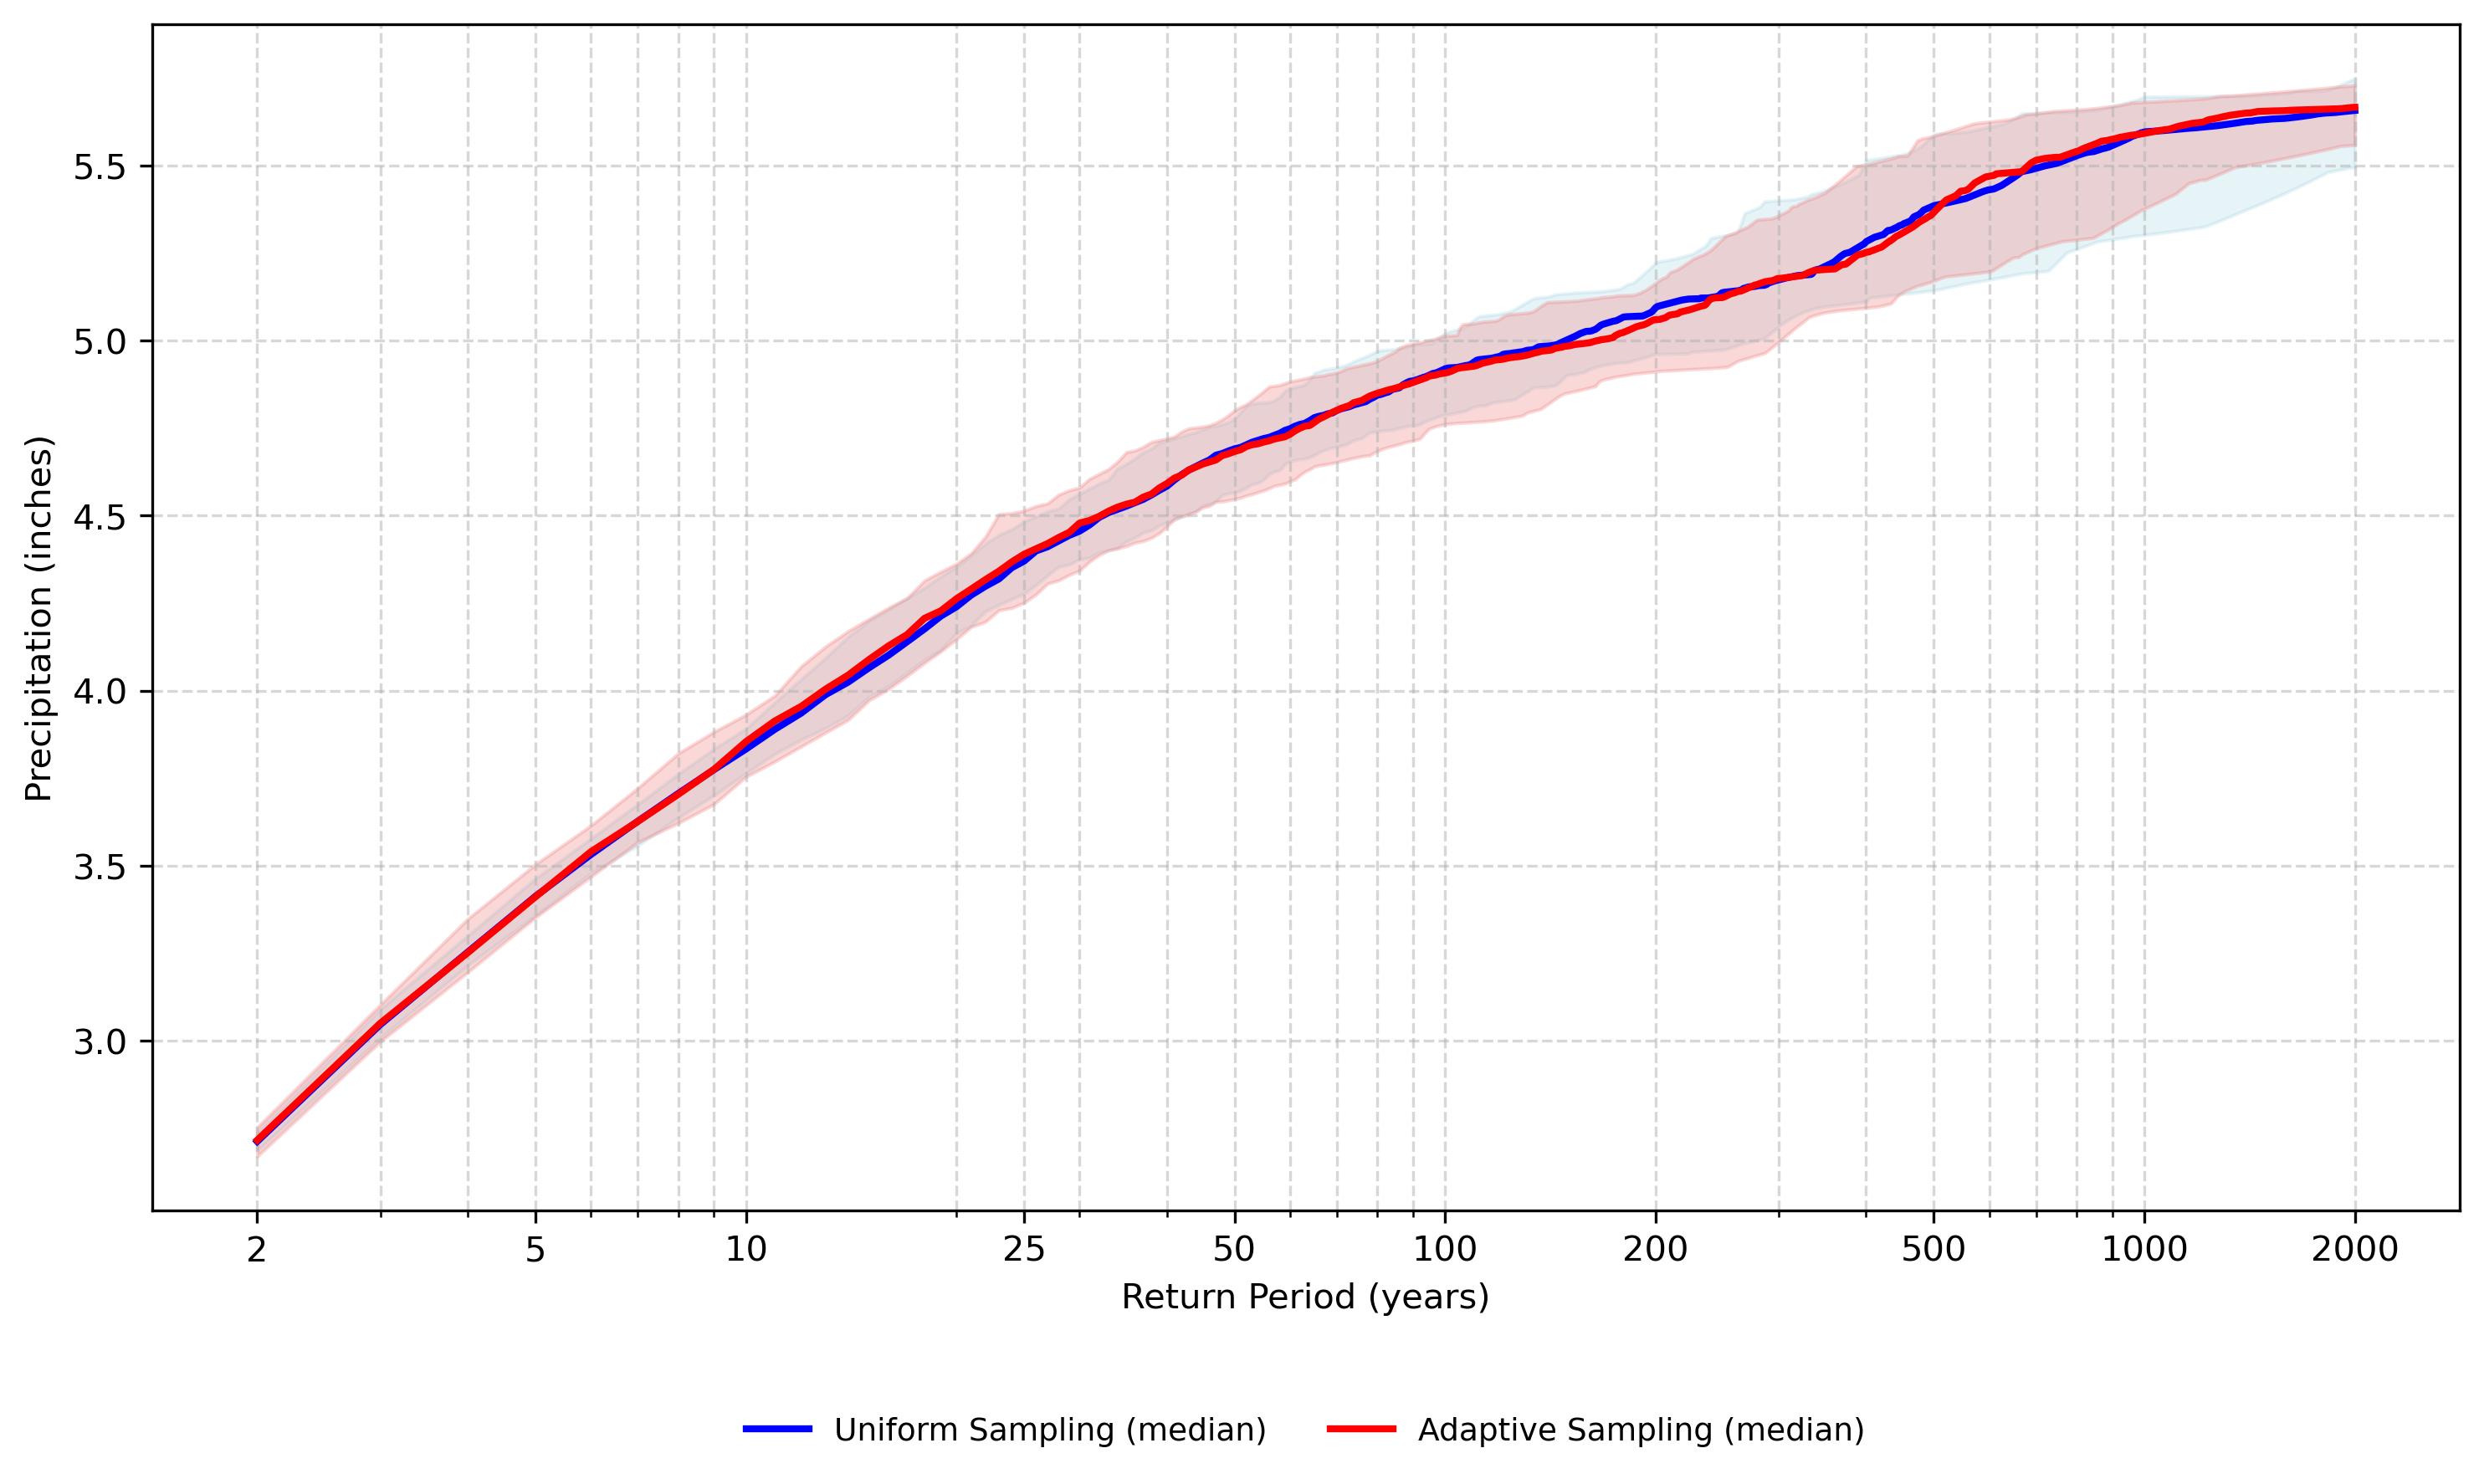

In [496]:
plot_two_return_period_summaries(
    summary1= summaries["Kanawha"],          # your first summary DataFrame
    summary2=adaptive_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Adaptive Sampling",
    title=""
)

In [48]:
watershed = watersheds["Duwamish"]

In [52]:
params = AdaptParams(
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"],
    sd_y_n=watershed.watershed_stats["range_y"],

    mu_x_w=watershed.domain_stats["x"],
    mu_y_w=watershed.domain_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"]/np.sqrt(12),
    sd_y_w=watershed.domain_stats["range_y"]/np.sqrt(12),

    rho_n=0,      # correlation narrow
    rho_w=0,       # correlation wide
    mix=0.5,         # initial mixture weight for narrow
)

sampler = AdaptiveMixtureSampler(
    data=watershed,                   
    params=params,
    precip_cube=watershed.cumulative_precip,
    seed=42
)

# Adapt does NOT take data or seed
history = sampler.adapt(num_iterations=10, samples_per_iter=1000, depth_threshold=0)

In [53]:
history

,iter,n,updated,mix,mu_x_n,mu_y_n,sd_x_n,sd_y_n,rho_n,beta_hat_reward
0,0,0,0,0.500000,-1.942311e+06,2.965860e+06,69459.812896,67306.945629,0.000000,NaN
1,1,1000,1,0.531351,-1.928568e+06,2.988683e+06,53483.858598,70118.690942,0.308634,0.604504
2,2,1000,1,0.580584,-1.920144e+06,2.999874e+06,50828.374635,71107.531759,0.465758,0.695462
3,3,1000,1,0.628900,-1.916351e+06,3.007296e+06,48200.230856,73097.389397,0.481666,0.741636
4,4,1000,1,0.651751,-1.916219e+06,3.005505e+06,46952.041199,74470.569356,0.508874,0.705072
5,5,1000,1,0.679974,-1.916044e+06,3.009696e+06,47253.931037,75369.970310,0.536255,0.745827
6,6,1000,1,0.705765,-1.913519e+06,3.008835e+06,47048.534138,77105.282353,0.516027,0.765945
7,7,1000,1,0.709732,-1.915410e+06,3.003898e+06,45745.742230,78254.797360,0.523218,0.718987
8,8,1000,1,0.731151,-1.919425e+06,3.002596e+06,44060.467745,74940.959716,0.516228,0.781127
9,9,1000,1,0.748166,-1.918497e+06,3.003529e+06,44685.526464,76383.190776,0.500835,0.787870


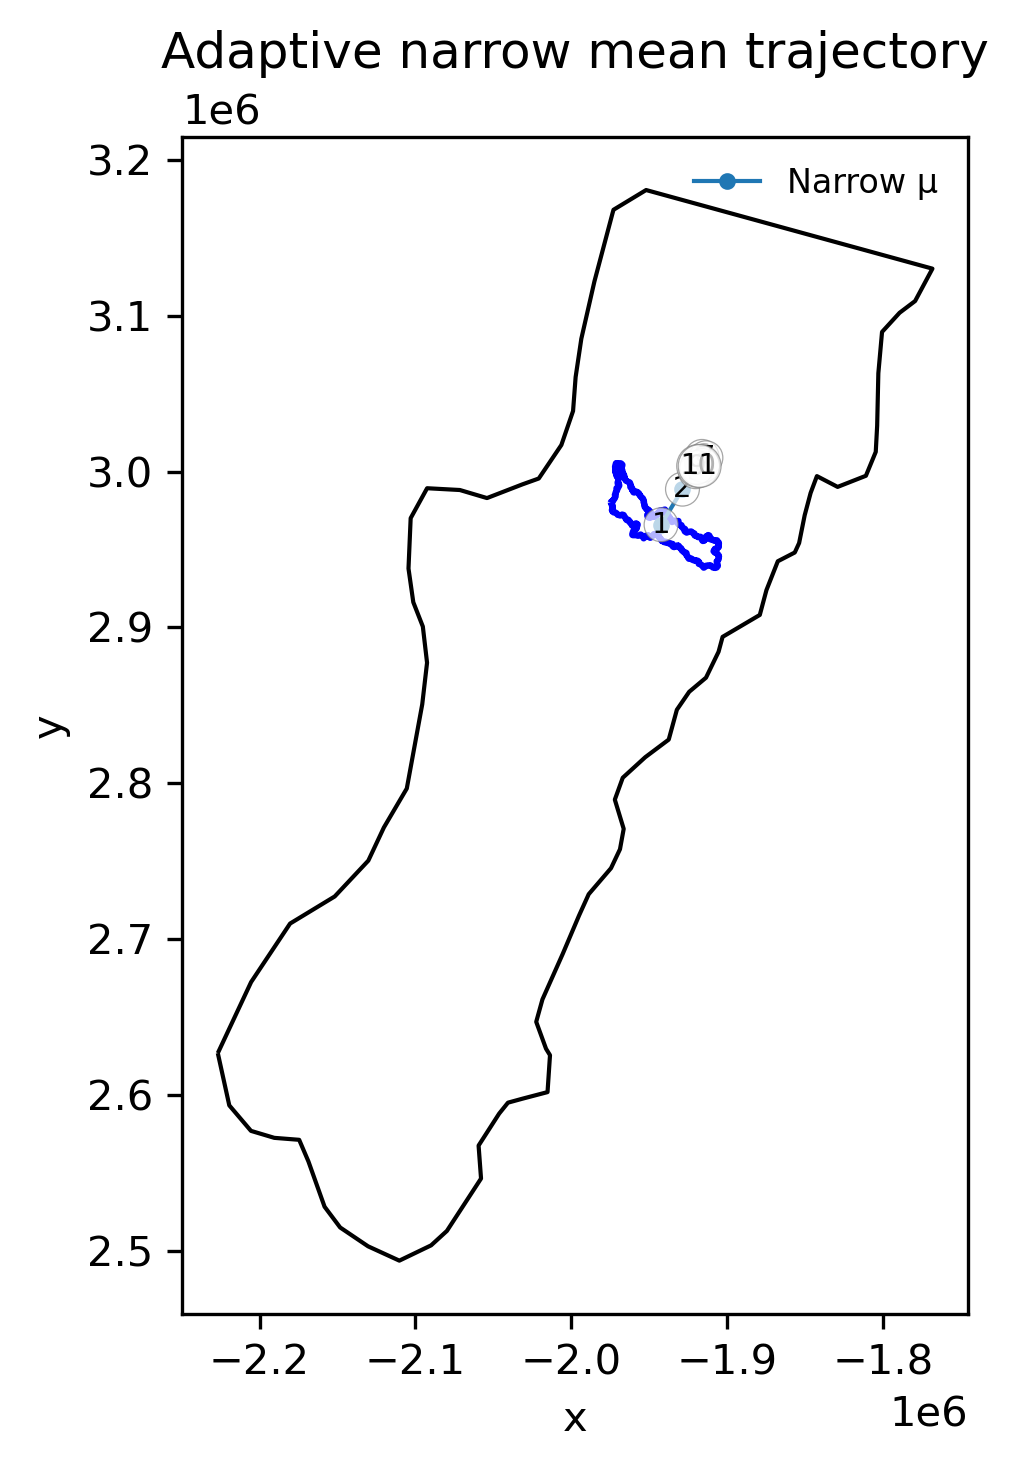

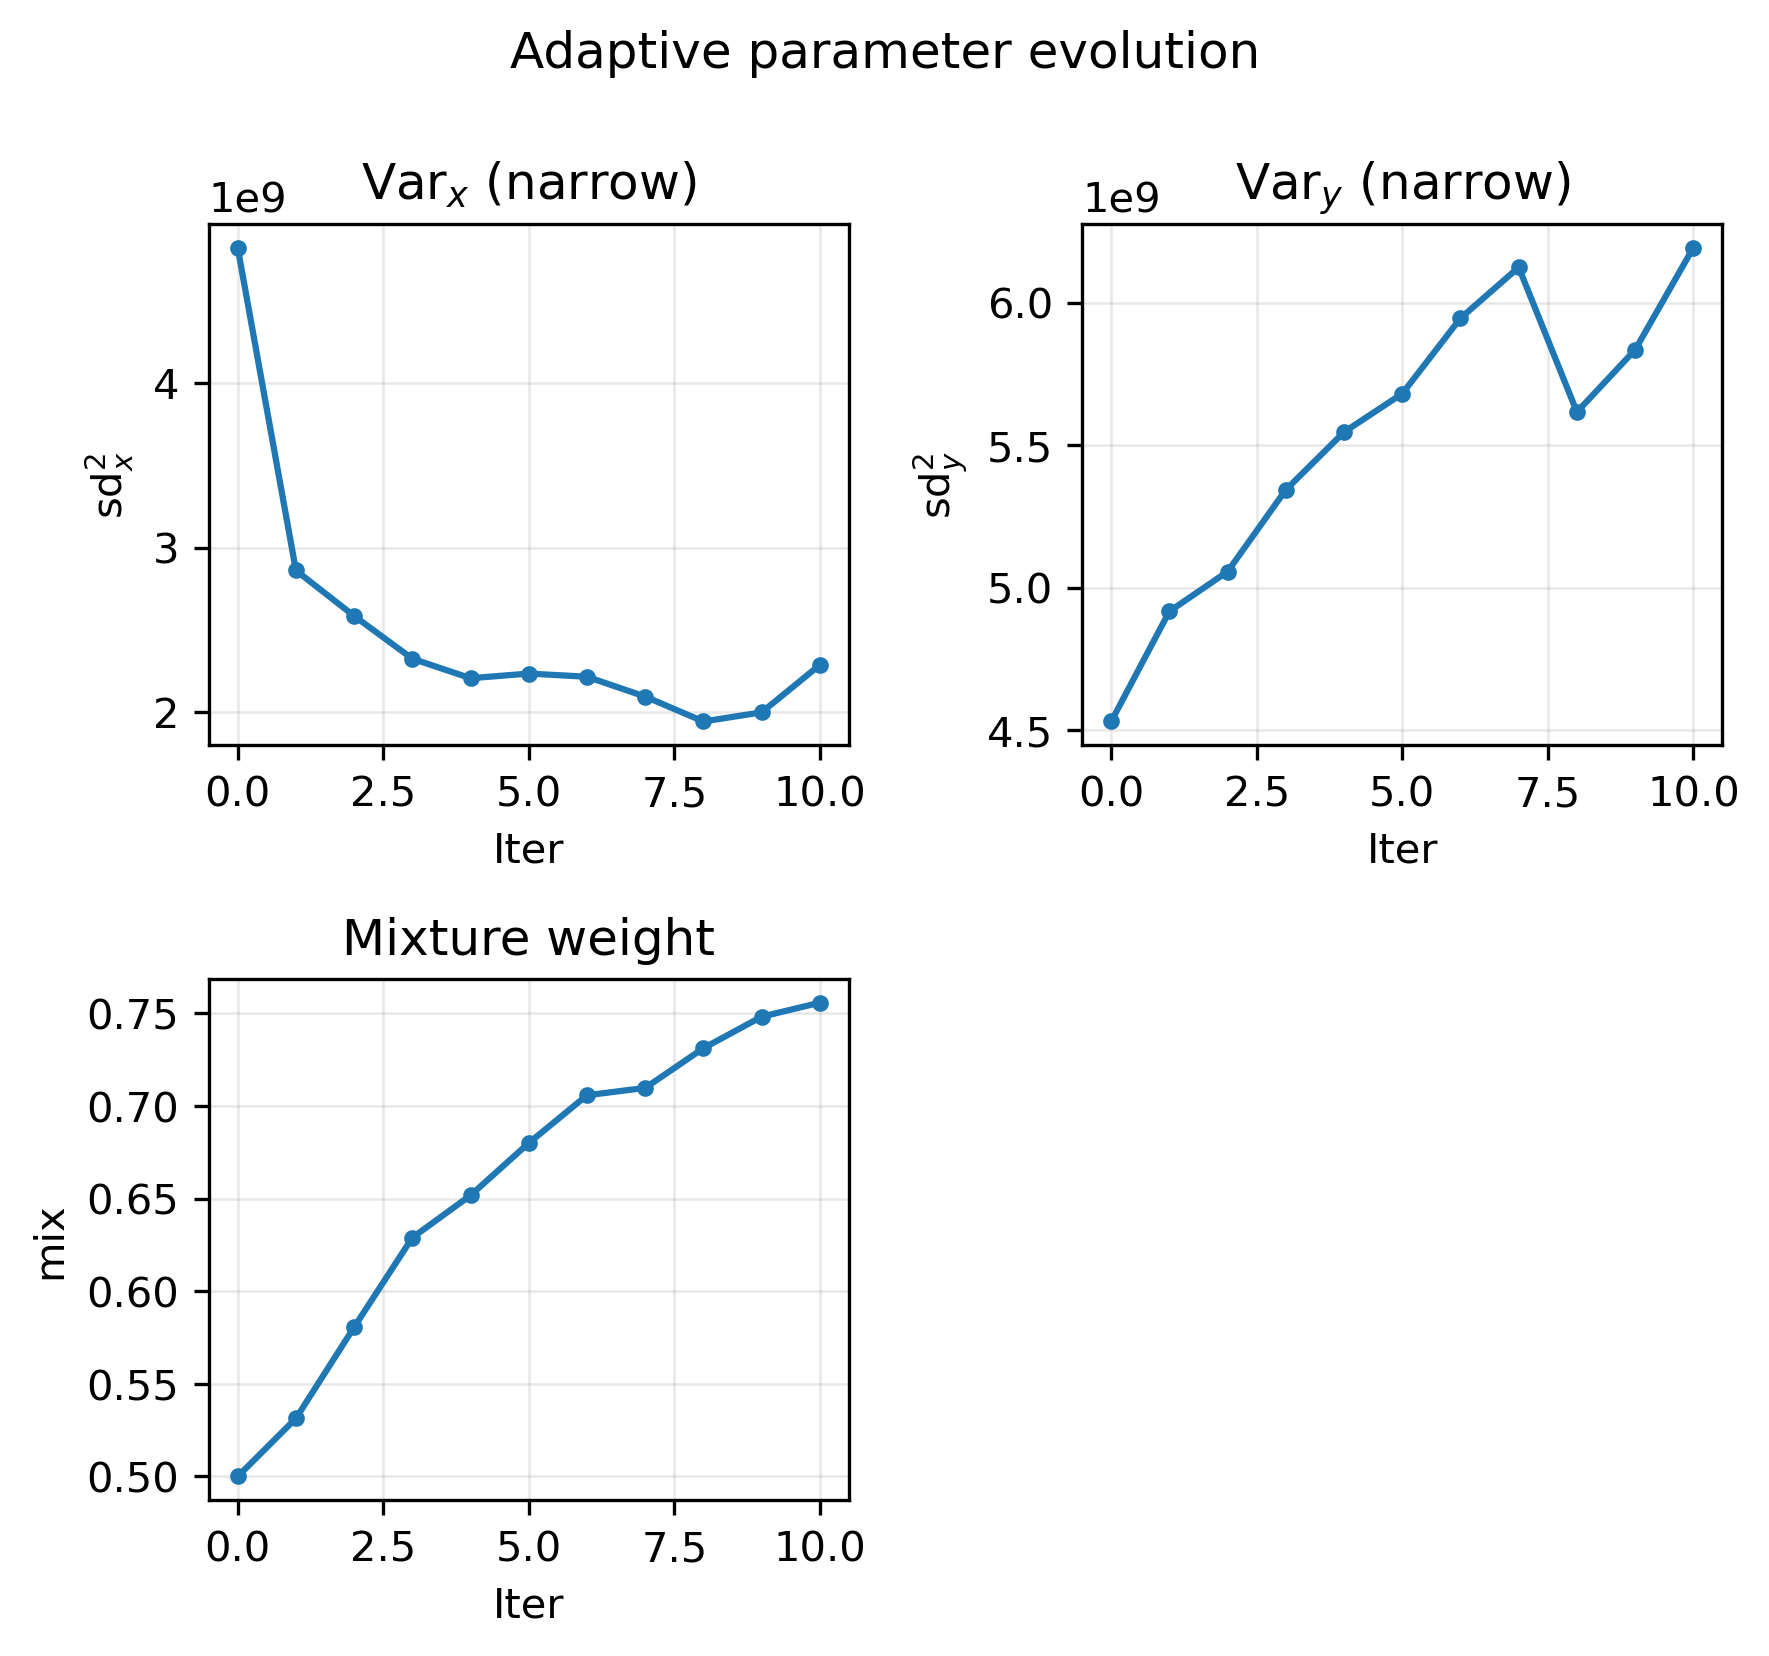

In [54]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="duwamish_ais")

In [31]:
final_df = sampler.sample_final(n=10000, num_realizations=50, with_depths=True)

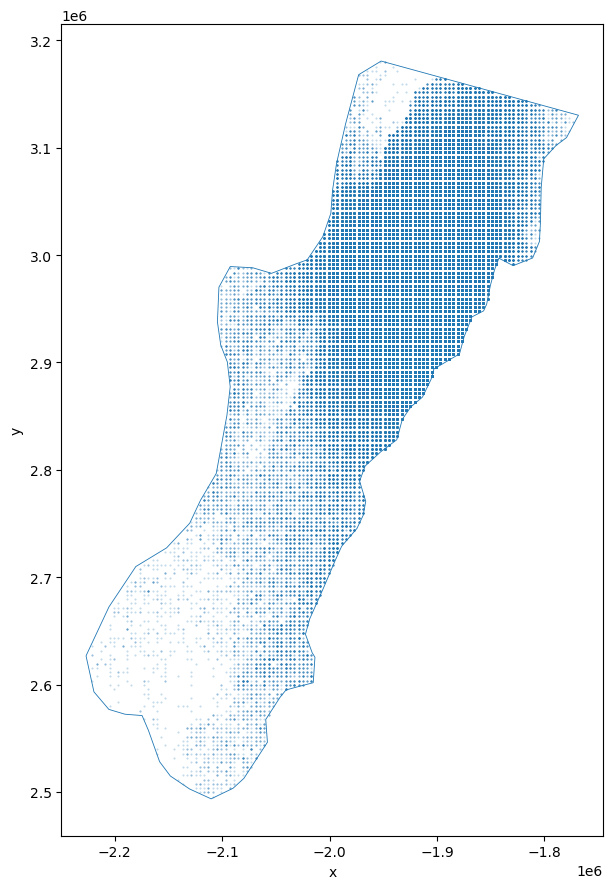

In [527]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(final_df.newx, final_df.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [528]:
adaptive_summary = summarize_depths_by_return_period(
    df=final_df,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
    use_common_min=False
)

In [529]:
m = metrics(summaries["Duwamish"],adaptive_summary)
m

,n_points,rp_min_used,rp_max_used,rmse_mean,rmse_median,rmse_ci95_low,rmse_ci95_high,rmse_ci90_low,rmse_ci90_high,me_mean,...,me_ci95_low,me_ci95_high,me_ci90_low,me_ci90_high,diff_at_maxrp_mean,diff_at_maxrp_median,diff_at_maxrp_ci95_low,diff_at_maxrp_ci95_high,diff_at_maxrp_ci90_low,diff_at_maxrp_ci90_high
0,1999,2.0,2000.0,0.19265,0.249481,0.104382,0.524433,0.162826,0.319517,-0.161486,...,-0.067491,-0.403924,-0.136877,-0.217384,-0.387547,-0.619368,-0.043001,-0.581118,-0.016344,-0.739193


In [530]:
adaptive_summary

,RP,mean_in,median_in,ci90_low_in,ci90_high_in,ci95_low_in,ci95_high_in,n_realizations,n_samples_per_realization
0,2,6.047230,6.036590,5.955400,6.165013,5.939988,6.173660,50,10000
1,3,6.854054,6.847203,6.677227,6.995880,6.656690,7.041866,50,10000
2,4,7.364498,7.360768,7.172652,7.544975,7.156425,7.571734,50,10000
3,5,7.748463,7.730191,7.528936,8.007179,7.521875,8.039582,50,10000
4,6,8.064784,8.052715,7.805443,8.344382,7.775904,8.396720,50,10000
...,...,...,...,...,...,...,...,...,...
1994,1996,14.284603,14.274109,13.196523,15.281377,13.090996,15.441611,50,10000
1995,1997,14.285144,14.275539,13.196729,15.282229,13.091109,15.442056,50,10000
1996,1998,14.285686,14.276970,13.196934,15.283082,13.091222,15.442501,50,10000
1997,1999,14.286227,14.278401,13.197140,15.283934,13.091335,15.442946,50,10000


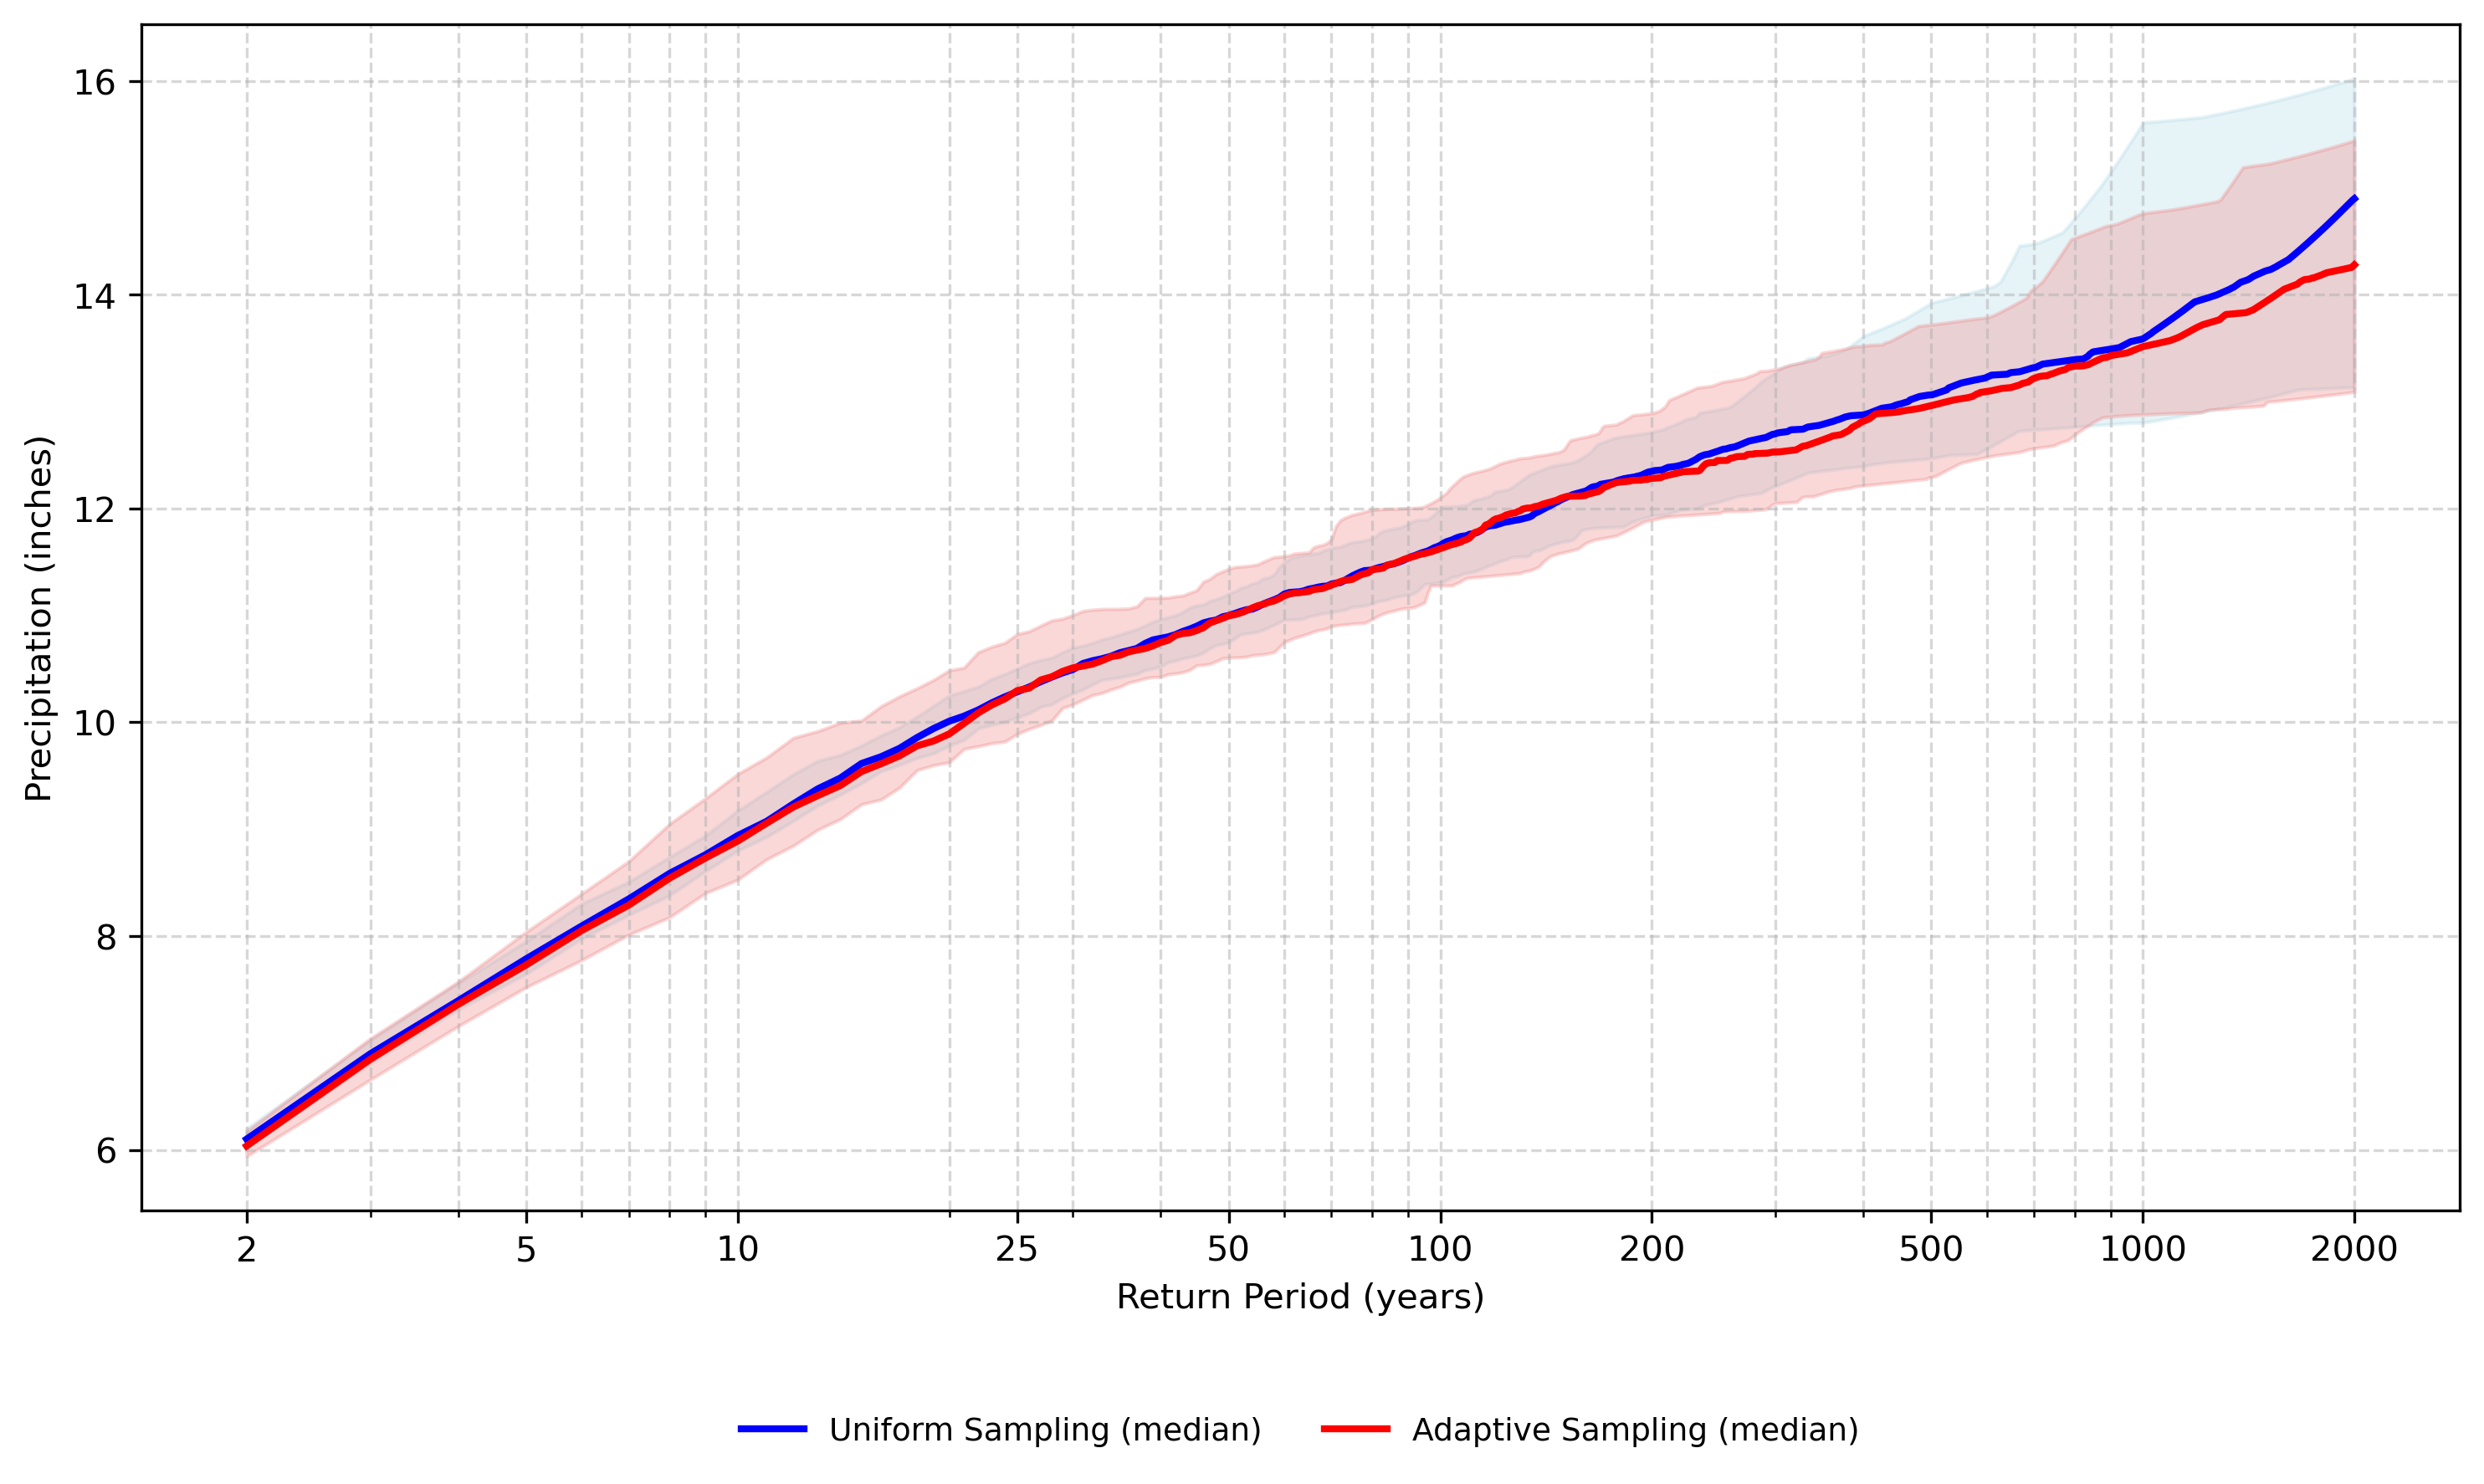

In [531]:
plot_two_return_period_summaries(
    summary1= summaries["Duwamish"],          # your first summary DataFrame
    summary2=adaptive_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Adaptive Sampling",
    title=""
)

In [10]:
watershed = watersheds["Denton"]

In [11]:
params = AdaptParams(
    mu_x_n=watershed.domain_stats["x"],
    mu_y_n=watershed.domain_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"],
    sd_y_n=watershed.watershed_stats["range_y"],

    mu_x_w=watershed.domain_stats["x"],
    mu_y_w=watershed.domain_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"]/np.sqrt(12),
    sd_y_w=watershed.domain_stats["range_y"]/np.sqrt(12),

    rho_n=0,      # correlation narrow
    rho_w=0,       # correlation wide
    mix=0.8,         # initial mixture weight for narrow
)

sampler = AdaptiveMixtureSampler(
    data=watershed,                   
    params=params,
    precip_cube=watershed.cumulative_precip,
    seed=42
)

# Adapt does NOT take data or seed
history = sampler.adapt(num_iterations=10, samples_per_iter=1000, depth_threshold=0)

In [12]:
history

,iter,n,updated,mix,mu_x_n,mu_y_n,sd_x_n,sd_y_n,rho_n,beta_hat_reward
0,0,0,0,0.800000,445654.058843,1.016894e+06,72093.816157,82380.632370,0.000000,NaN
1,1,1000,1,0.581059,432496.938791,1.032929e+06,78593.778334,99503.855266,0.014290,0.070196
2,2,1000,1,0.428404,416918.709144,1.051024e+06,87683.900391,106710.570544,0.035189,0.072211
3,3,1000,1,0.319463,398990.068920,1.065211e+06,96394.394952,112816.298945,0.033991,0.065267
4,4,1000,1,0.246949,382380.766305,1.075474e+06,104394.514017,117091.068191,0.068442,0.077750
5,5,1000,1,0.197863,363952.597004,1.085232e+06,112518.773248,116686.654027,0.080649,0.083328
6,6,1000,1,0.162802,343670.721042,1.093711e+06,118035.064647,118049.364267,0.080900,0.080994
7,7,1000,1,0.139254,322357.732163,1.102504e+06,122716.449524,115967.558106,0.097895,0.084309
8,8,1000,1,0.120564,297763.477220,1.108299e+06,128907.140977,114952.003513,0.111526,0.076952
9,9,1000,1,0.111135,271230.895650,1.113252e+06,134354.068716,112237.901493,0.114142,0.089135


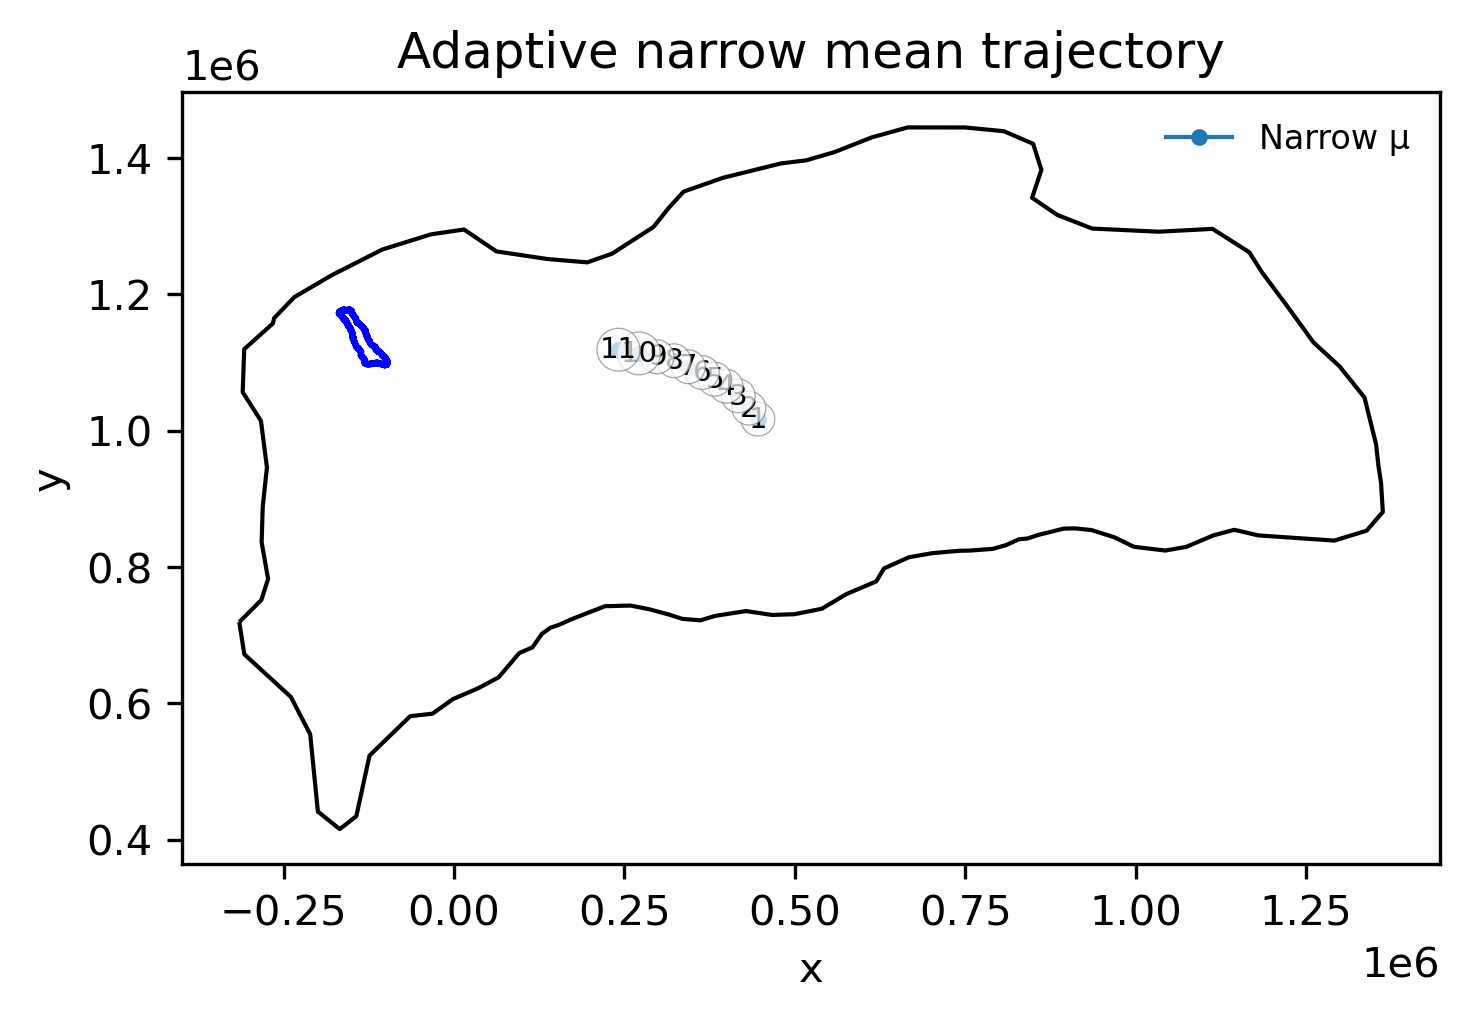

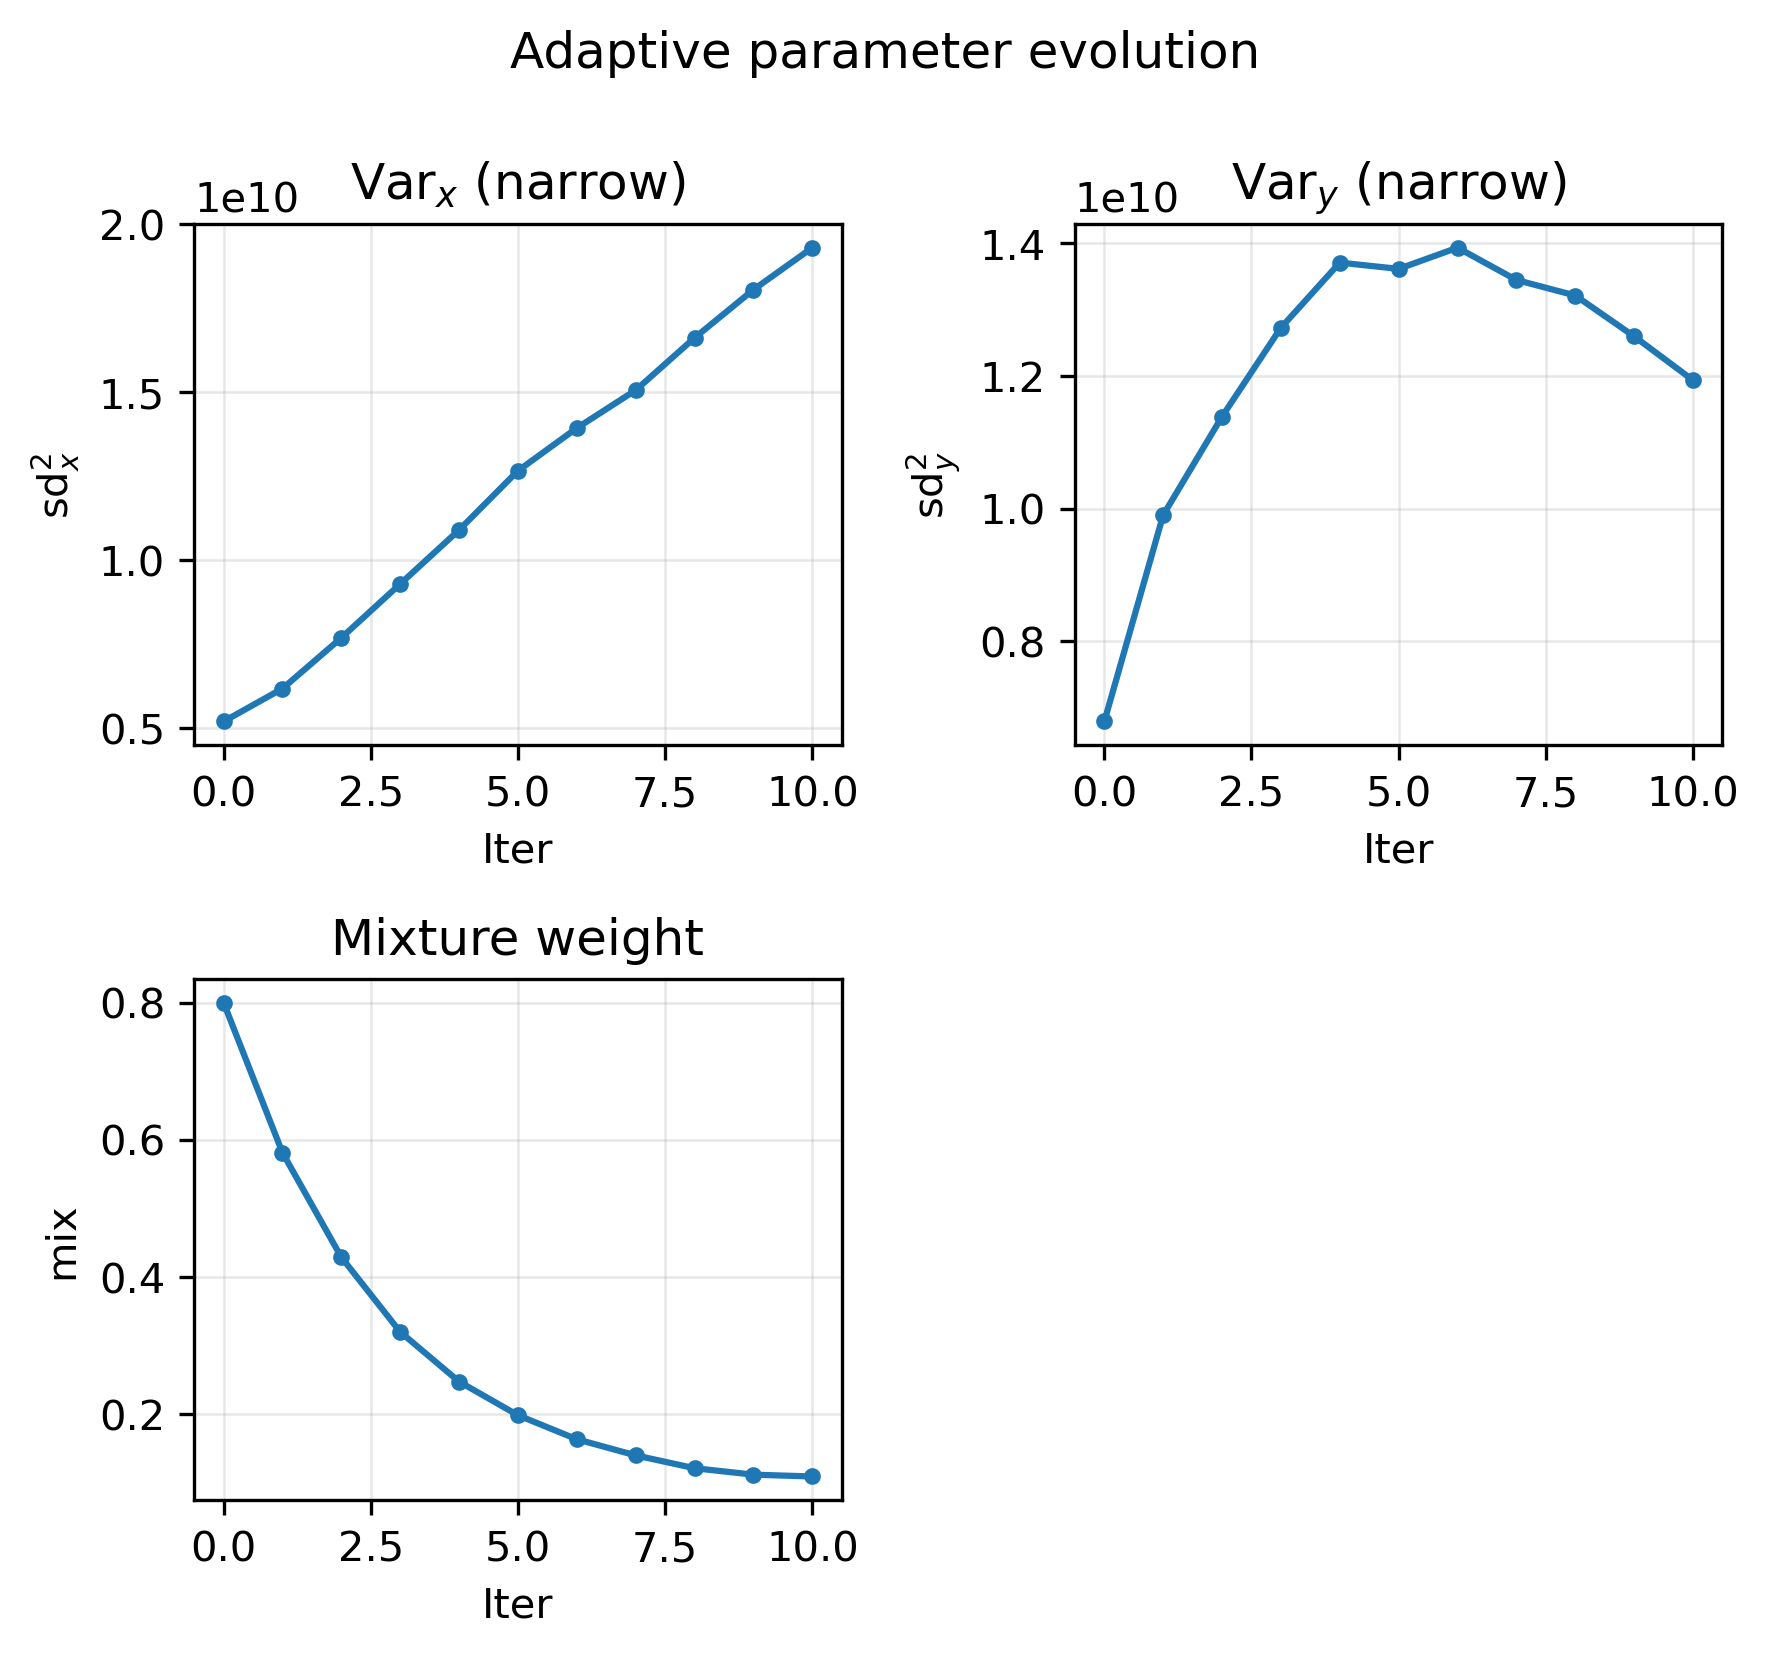

In [13]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="denton_ais")

In [561]:
final_df = sampler.sample_final(n=10000, num_realizations=50, with_depths=True)

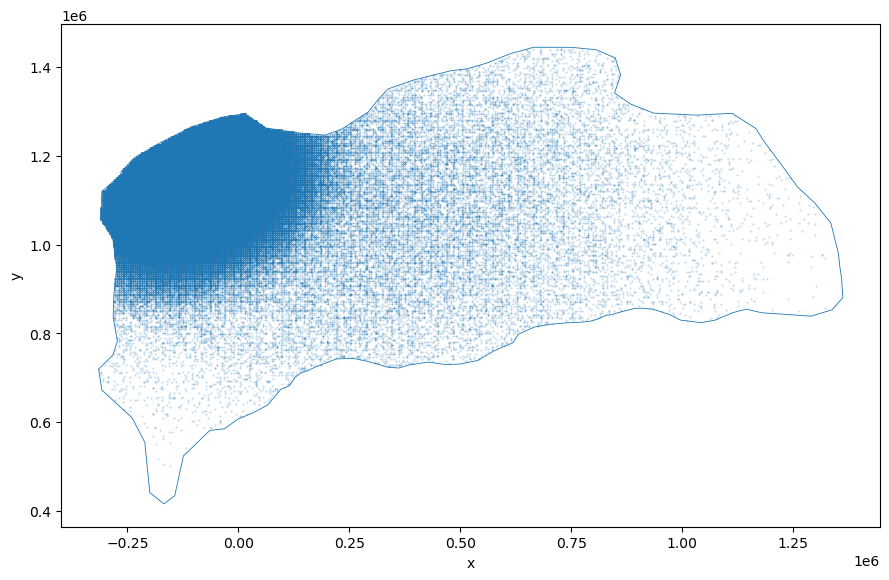

In [562]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(final_df.newx, final_df.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [564]:
adaptive_summary = summarize_depths_by_return_period(
    df=final_df,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
    use_common_min=True
)

In [565]:
m = metrics(summaries["Denton"],adaptive_summary)
m

,n_points,rp_min_used,rp_max_used,rmse_mean,rmse_median,rmse_ci95_low,rmse_ci95_high,rmse_ci90_low,rmse_ci90_high,me_mean,...,me_ci95_low,me_ci95_high,me_ci90_low,me_ci90_high,diff_at_maxrp_mean,diff_at_maxrp_median,diff_at_maxrp_ci95_low,diff_at_maxrp_ci95_high,diff_at_maxrp_ci90_low,diff_at_maxrp_ci90_high
0,1999,2.0,2000.0,0.612548,0.87379,1.795209,1.399849,1.751864,1.038409,0.204275,...,1.291896,-1.046492,1.276313,-0.865457,0.581061,0.513423,3.644555,-1.413285,3.641297,-1.186219


In [566]:
adaptive_summary

,RP,mean_in,median_in,ci90_low_in,ci90_high_in,ci95_low_in,ci95_high_in,n_realizations,n_samples_per_realization
0,2,5.322884,5.302040,5.197203,5.466057,5.184919,5.481661,50,10000
1,3,6.148133,6.150879,5.996181,6.273973,5.981405,6.304292,50,10000
2,4,6.682051,6.666661,6.530993,6.828969,6.521954,6.897112,50,10000
3,5,7.055180,7.054656,6.892411,7.228761,6.867750,7.245351,50,10000
4,6,7.350514,7.344071,7.201812,7.476493,7.178964,7.535623,50,10000
...,...,...,...,...,...,...,...,...,...
1994,1996,28.192243,28.951509,22.998318,31.499466,22.153278,31.624191,50,10000
1995,1997,28.194474,28.952850,23.000124,31.500143,22.155710,31.624662,50,10000
1996,1998,28.196705,28.954191,23.001931,31.500820,22.158142,31.625133,50,10000
1997,1999,28.198937,28.955532,23.003738,31.501496,22.160574,31.625604,50,10000


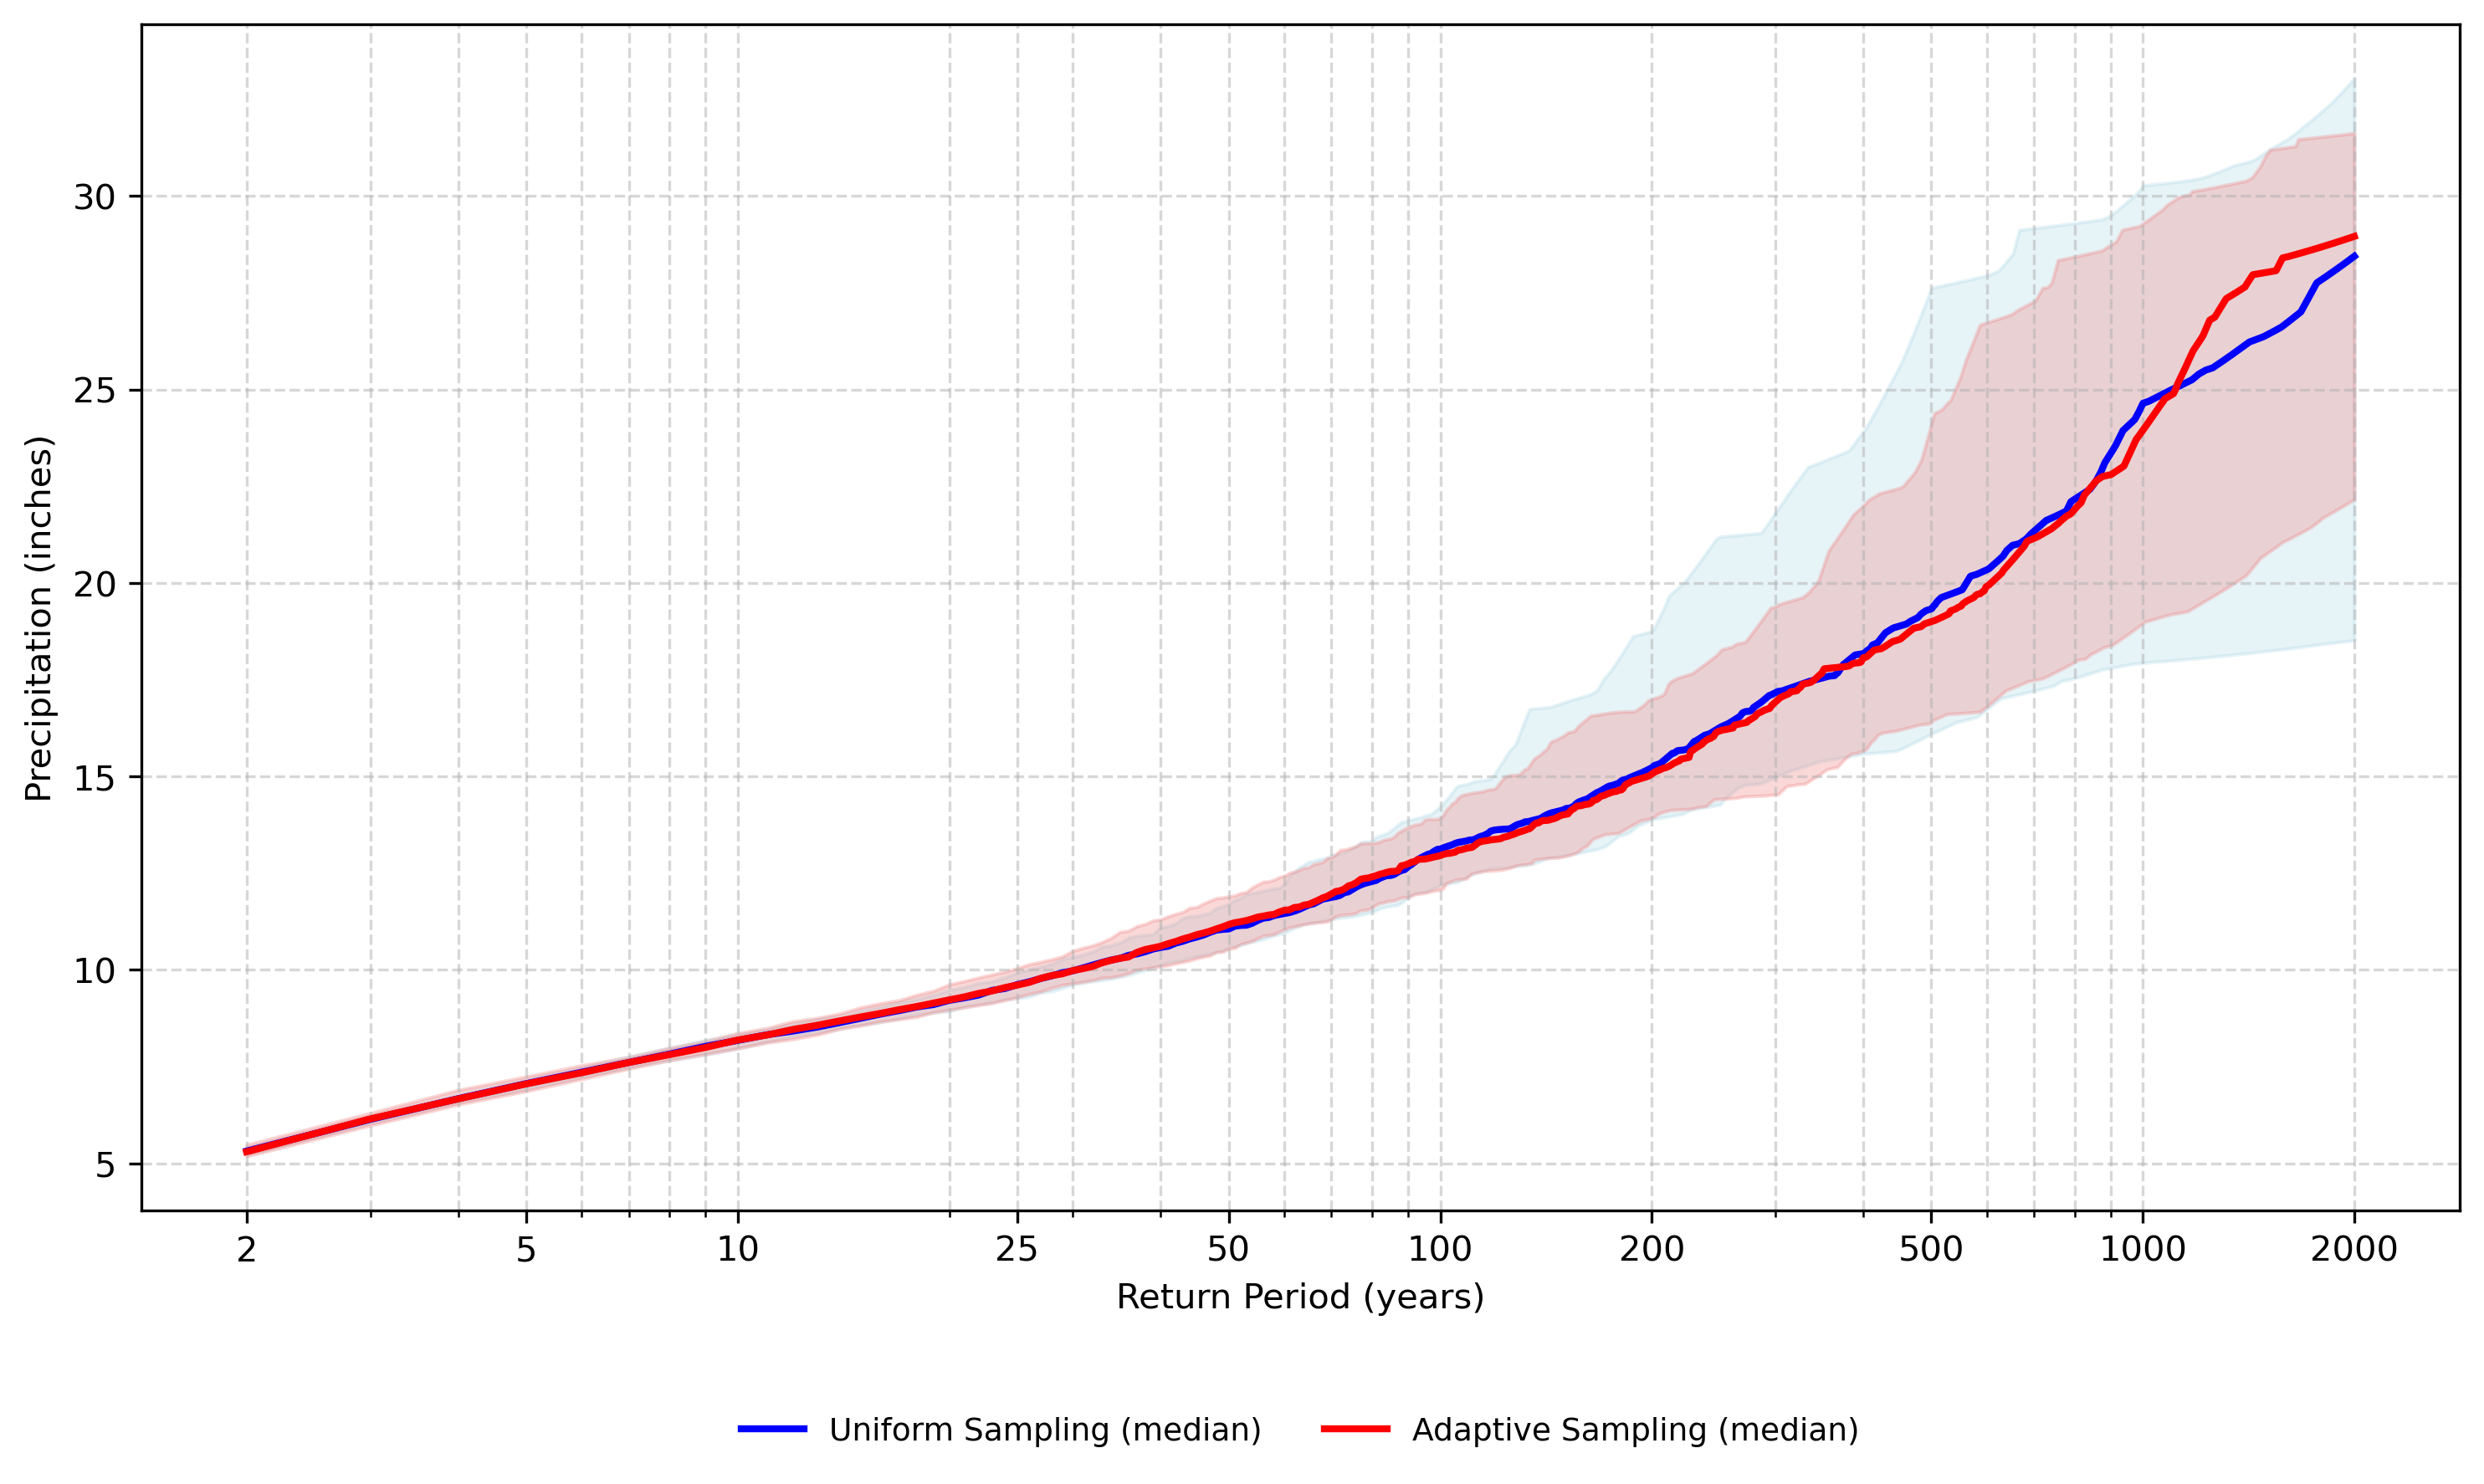

In [567]:
plot_two_return_period_summaries(
    summary1= summaries["Denton"],          # your first summary DataFrame
    summary2=adaptive_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Adaptive Sampling",
    title=""
)